**Team Members:** Nthabeleng Vilakazi, Nyandala Ramaru, Refiloe Elvis Phipa, Thabo Mahlangu, Lizette Loubser  

### Table of Contents
---
1. [Introduction](#intro)
 * Project Description
 * Problem Statement
 * Datasets and Variables
---
2. [Load Dependencies](#imports)
---
3. [Data Cleaning](#data)
 * Load Data
 * Merge Datasets
 * Handle Missing Data
 * Remove Target Outliers
---
4. [Exploratory Data Analysis](#EDA)
 * Data Summary Statistics
 * Univariate Analysis and Visualisation
 * Bivariate Analysis and Visualisation
 * Map Visualisation
---
5. [Data Preprocessing](#preprocessing) 
 * Feature Engineering
 * Encoding Categorical Data
 * Split Training Set Into Training and Validation Sets
 * Feature Scaling
 * Feature Selection

---
6. [Modelling](#modelling)
 * Linear Regression
 * Multiple Linear Regression
 * Polynomial Regression
 * Support Vector Regression
 * Random Forest Regression
 * Lasso Regression
 * Ridge Regression
 * CatBoost Regression
 * XGBoost Regression
 * LightGBM Regression
---
7. [Performance Evaluation](#evaluation)
 * Compare Models on Performance Metrics
 * Evaluate Best Models by Cross Validation
 * Hyperparameter Tuning on Best Models
 * Feature Importance of Best Models
---
8. [Model Analysis](#analysis)
---
9. [Conclusion](#conclusion)
---
10. [Save Model and Output](#save)

<a id="intro"></a>
## 1. Introduction  

### Project Description

Machine learning is a powerful branch of Artificial Intelligence, dating as far back as 1952,  developed to teach computer systems how to make decisions emanated from preexisting data. Mathematical algorithms are applied to training data which allows a machine to identify patterns and make predictions for unseen datasets.

Regression is a popular supervised statistical learning method that aims to predict the value of a dependent variable (y) based on an independent variable (x). The relationship between the variables can be linear or nonlinear.

The Zindi challenge, hosted by Sendy in partnership with insight2impact facility, is to build a regression model that will predict an accurate time of arrival for motobike deliveries from the pickup point to the destination of the package. An accurate arrival time will enhance customer communication and customer experience. In addition, the solution will help businesses reduce the cost of trade through better management of resources and planning.  

### Problem Statement
Build a regression model that will predict an accurate time of arrival for motobike deliveries from the pickup point to the destination of the package.

### Datasets and Variables  

The dataset provided by Sendy includes order details and rider metrics based on orders made on the Sendy platform. The challenge is to predict the estimated time of arrival for orders, from pick-up to drop-off. The training dataset is a subset of over 20,000 orders and only includes direct orders (i.e. Sendy “express” orders) with bikes in Nairobi. 

**train_data:** The dataset that will be used to train our model  
**test_data:** The dataset to which we will apply our model  
**riders:** Contains unique rider IDs, number of orders, age, rating and number of ratings

**Order details**  
* Order No: Unique number identifying the order  
* User Id: Unique number identifying the customer on a platform  
* Vehicle Type: For this competition limited to bikes, however in practice, Sendy service extends to trucks and vans  
* Platform Type: Platform used to place the order (there are 4 types)  
* Personal or Business: Customer type  

**Placement times**  
* Placement: Day of Month (i.e 1-31)  
* Placement: Weekday (Monday = 1)  
* Placement: Time - Time of day the order was placed  

**Confirmation times**  
* Confirmation: Day of Month (i.e 1-31)  
* Confirmation: Weekday (Monday = 1)  
* Confirmation: Time (Time of day the order was confirmed by a rider)  

**Arrival at Pickup times**  
* Arrival at Pickup: Day of Month (i.e 1-31)  
* Arrival at Pickup: Weekday (Monday = 1)  
* Arrival at Pickup: Time (Time of day the rider arrived at the location to pick up the order - as marked by the rider through the Sendy application)  

**Pickup times**  
* Pickup: Day of Month (i.e 1-31)  
* Pickup: Weekday (Monday = 1)  
* Pickup: Time (Time of day the rider picked up the order - as marked by the rider through the Sendy application)  

**Arrival at Destination times** (not in Test set)  
* Arrival at Destination: Day of Month (i.e 1-31)  
* Arrival at Destination: Weekday (Monday = 1)  
* Arrival at Destination: Time (Time of day the rider arrived at the destination to deliver the order - as marked by the rider through the Sendy application)  
* Distance covered (KM): The distance from Pickup to Destination  
* Temperature: Temperature at the time of order placement in Degrees Celsius (measured every three hours)  
* Precipitation in Millimeters: Precipitation at the time of order placement (measured every three hours)  
* Pickup Latitude and Longitude: Latitude and longitude of pick up location  
* Destination Latitude and Longitude: Latitude and longitude of delivery location  
* Rider ID: ID of the Rider who accepted the order  
* Time from Pickup to Arrival: Time in seconds between ‘Pickup’ and ‘Arrival at Destination’ **(Target variable)**    

**Rider metrics**  
* Rider ID: Unique number identifying the rider (same as in order details)  
* No of Orders: Number of Orders the rider has delivered  
* Age: Number of days since the rider delivered the first order  
* Average Rating: Average rating of the rider  
* No of Ratings: Number of ratings the rider has received. Rating an order is optional for the customer

<a id="imports"></a>
## 2. Load Dependencies

In [3]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Prerequisites
import sys
!{sys.executable} -m pip install scikit-learn folium pygeohash catboost xgboost lightgbm

# Load Dependencies
import time
import pickle
import folium
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import pygeohash as gh
import lightgbm as lgbm
import matplotlib.pyplot as plt
import folium.plugins as plugins

from math import sqrt
from sklearn import metrics
from sklearn.svm import SVR
from folium.plugins import HeatMap
from IPython.display import display
from catboost import CatBoostRegressor
from scipy.stats import boxcox, zscore
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")

<a id="data"></a>
## 3. Data Cleaning

### Load Data

In [4]:
train_df = pd.read_csv('https://raw.githubusercontent.com/Lizette95/regression-predict-api-template/master/utils/data/Train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/Lizette95/regression-predict-api-template/master/utils/data/Test.csv')
riders = pd.read_csv('https://raw.githubusercontent.com/Lizette95/regression-predict-api-template/master/utils/data/Riders.csv')

In [5]:
riders.head()

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156


In [6]:
train_df.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [7]:
test_df.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


### Merge Datasets

In [8]:
# List columns not present in the test dataset
[name for name in train_df.columns if name not in test_df.columns]

['Arrival at Destination - Day of Month',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Arrival at Destination - Time',
 'Time from Pickup to Arrival']

Our target variable for this project is 'Time from Pickup to Arrival' (in seconds), therefore it is not included in our testing set. All other information about the day/time of arrival is also not included.

In [9]:
# Merge datasets
train_data = pd.merge(train_df,riders,on='Rider Id',how='left')
test_data = pd.merge(test_df,riders,on='Rider Id',how='left')

# Rename columns
train_data.columns = [column.replace("Of","of") for column in train_data.columns]
train_data.columns = [column.replace("_"," ") for column in train_data.columns]
train_data.columns = [column.replace("(Mo = 1)"," ") for column in train_data.columns]
train_data = train_data.rename(columns=lambda x: x.strip())
test_data.columns = [column.replace("Of","of") for column in test_data.columns]
test_data.columns = [column.replace("_"," ") for column in test_data.columns]
test_data.columns = [column.replace("(Mo = 1)"," ") for column in test_data.columns]
test_data = test_data.rename(columns=lambda x: x.strip())

In [10]:
train_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday,Placement - Time,Confirmation - Day of Month,Confirmation - Weekday,Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday,Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday,Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No of Orders,Age,Average Rating,No of Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533


In [11]:
test_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday,Placement - Time,Confirmation - Day of Month,Confirmation - Weekday,Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday,Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday,Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No of Orders,Age,Average Rating,No of Ratings
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868,488,273,14.4,45
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26,833,460,13.1,67
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685,487,560,13.7,44
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858,4761,1120,14.1,1010


### Handle Missing Data

There can be numerous reasons as to why datasets can have missing values. It is critical to identify how many values are missing because they can provide insight into potential patterns or cause the misrepresentation of features. The proportion of missing data will determine how the data is further handled.

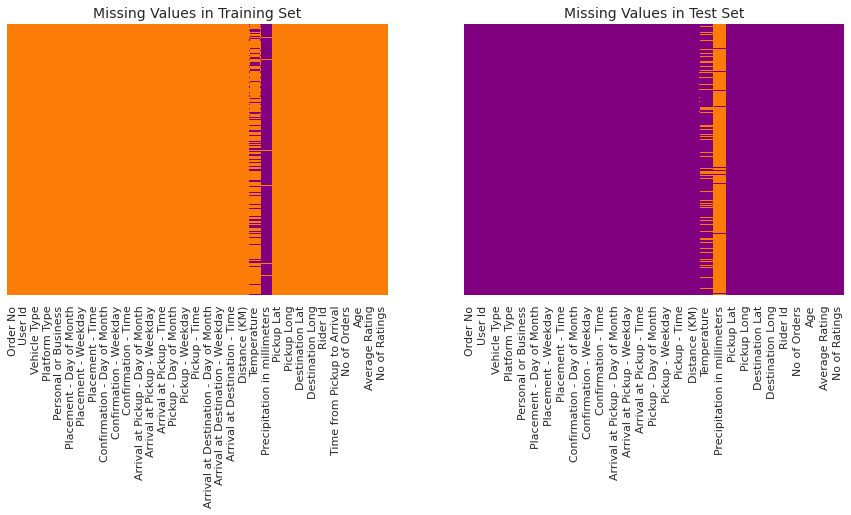

,% missing training set,% missing testing set
Precipitation in millimeters,97.40,97.18
Temperature,20.59,20.33


In [12]:
# Check columns for missing values
fig,axis = plt.subplots(ncols=2, figsize=(15, 5))

#Training set
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False,cmap=['#fb7d07','purple'],ax=axis[0])
axis[0].set_title('Missing Values in Training Set',fontsize=14)
#Testing set
sns.heatmap(test_data.isnull(),yticklabels=False,cbar=False,cmap=['purple','#fb7d07'],ax=axis[1])
axis[1].set_title('Missing Values in Test Set',fontsize=14)

plt.show()

# Calculate percentage missing values
train = round((train_data.isnull().sum()/train_data.isnull().count())*100,2)
test = round((test_data.isnull().sum()/test_data.isnull().count())*100,2)
d = {'% missing training set': train, '% missing testing set': test}
pd.DataFrame(data=d).sort_values(by='% missing training set',ascending=False).head(2)

**Dealing with missing data:**
* We can remove the 'Precipitation in millimeters' column from both datasets, as 97% of the data is missing.
* We can impute missing values in the 'Temperature' column with the average temperature at the time (hour) the order was placed, as only 20% of the data is missing. We use this information from the training set to impute missing values in the testing set.

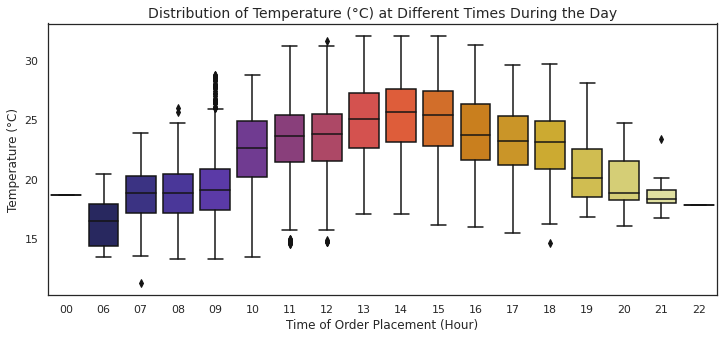

In [13]:
# Drop 'Precipitation in millimeters' column
train_data.drop('Precipitation in millimeters',axis=1,inplace=True)
test_data.drop('Precipitation in millimeters',axis=1,inplace=True)

# Create 24h time bins for when orders were placed
train_data['Placement - Time(bins)'] = pd.to_datetime(pd.to_datetime(train_data['Placement - Time']).dt.strftime('%H:%M:%S')).dt.strftime('%H')
test_data['Placement - Time(bins)'] = pd.to_datetime(pd.to_datetime(test_data['Placement - Time']).dt.strftime('%H:%M:%S')).dt.strftime('%H')

fig,axis = plt.subplots(figsize=(12,5))
sns.boxplot(x='Placement - Time(bins)',y='Temperature',data=train_data,palette='CMRmap')
plt.title('Distribution of Temperature (°C) at Different Times During the Day',fontsize=14)
plt.xlabel('Time of Order Placement (Hour)')
plt.ylabel('Temperature (°C)')
plt.show()

# Impute temperature for missing values
train_data['Temperature'] = train_data['Temperature'].fillna(round(train_data.groupby('Placement - Time(bins)')['Temperature'].transform('mean'),1))
test_data['Temperature'] = test_data['Temperature'].fillna(round(train_data.groupby('Placement - Time(bins)')['Temperature'].transform('mean'),1))

### Remove Target Outliers

Outliers are values which deviate immensely from other observations. It is important to identify outliers because the performance of many algorithms is sensitive to them, leading to inaccurate models and consequently poor predictions.

In Kenya, the [maximum travelling speed](https://www.rhinocarhire.com/Drive-Smart-Blog/Drive-Smart-Kenya.aspx) allowed on roads outside of towns and cities is 110km/h. We allow a margin of error of +10km/h to remove unrealistic outliers, based on the minimum travel time per kilometer:  

$Time = \frac{Distance}{Speed} =  \frac{1km}{120km/h} = 30 {seconds/km} $

From the above calculation, we can exclude outliers from the target variable based on the distance travelled in kilometers:

When Distance = 1 km (Exclude data if Time from Pickup to Arrival < 30 seconds)
<br>
When Distance = 2 km (Exclude data if Time from Pickup to Arrival < 60 seconds)
<br>
When Distance = 3 km (Exclude data if Time from Pickup to Arrival < 90 seconds)
<br>
...  
etc.

In [14]:
#Identify outliers in target variable
train_data['Outlier'] = (train_data['Distance (KM)']*30) > train_data['Time from Pickup to Arrival']
print("There are " + str(len(train_data[train_data['Outlier']==True])) + " outliers in our target variable.")

There are 876 outliers in our target variable.


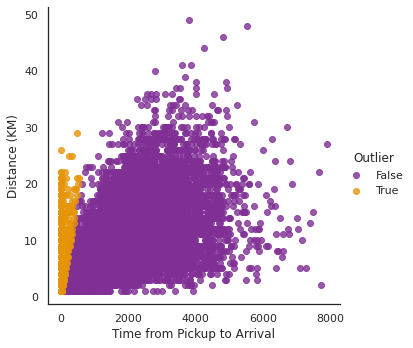

In [15]:
ax = sns.lmplot(x='Time from Pickup to Arrival', y='Distance (KM)', data=train_data, hue='Outlier', palette='CMRmap', fit_reg=False)
plt.xlabel('Time from Pickup to Arrival')
plt.ylabel('Distance (KM)')
plt.setp(ax._legend.get_title(), fontsize=12)

plt.show()

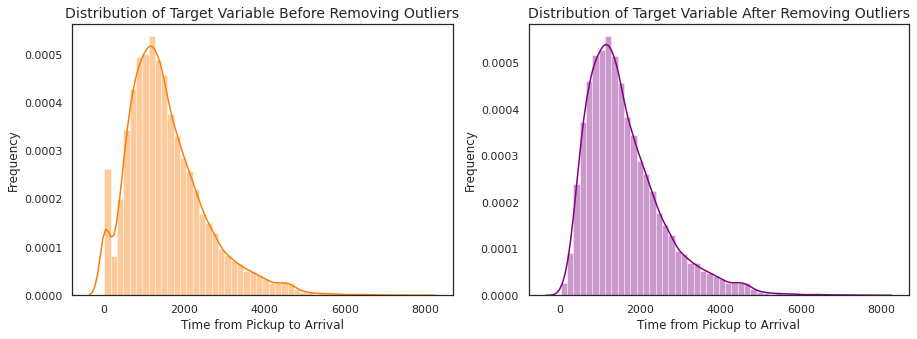

In [16]:
# Remove outliers
new_train_data = train_data[train_data['Outlier'] == False]
fig,axis = plt.subplots(ncols=2, figsize=(15, 5))

# Before removing outliers
sns.distplot(train_data['Time from Pickup to Arrival'],ax=axis[0],color='#fb7d07')
axis[0].set_title('Distribution of Target Variable Before Removing Outliers',fontsize=14)
axis[0].set_xlabel('Time from Pickup to Arrival')
axis[0].set_ylabel('Frequency')
# After removing outliers
sns.distplot(new_train_data['Time from Pickup to Arrival'],ax=axis[1],color='purple')
axis[1].set_title('Distribution of Target Variable After Removing Outliers',fontsize=14)
axis[1].set_xlabel('Time from Pickup to Arrival')
axis[1].set_ylabel('Frequency')

plt.show()

# Remove outlier column
train_data = train_data[train_data['Outlier'] == False]
train_data = train_data.drop(['Outlier'],axis=1)

<a id="EDA"></a>
## 4. Exploratory Data Analysis

### Data Summary Statistics

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20325 entries, 0 to 21200
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Order No                               20325 non-null  object 
 1   User Id                                20325 non-null  object 
 2   Vehicle Type                           20325 non-null  object 
 3   Platform Type                          20325 non-null  int64  
 4   Personal or Business                   20325 non-null  object 
 5   Placement - Day of Month               20325 non-null  int64  
 6   Placement - Weekday                    20325 non-null  int64  
 7   Placement - Time                       20325 non-null  object 
 8   Confirmation - Day of Month            20325 non-null  int64  
 9   Confirmation - Weekday                 20325 non-null  int64  
 10  Confirmation - Time                    20325 non-null  object 
 11  Ar

In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7068 entries, 0 to 7067
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Order No                          7068 non-null   object 
 1   User Id                           7068 non-null   object 
 2   Vehicle Type                      7068 non-null   object 
 3   Platform Type                     7068 non-null   int64  
 4   Personal or Business              7068 non-null   object 
 5   Placement - Day of Month          7068 non-null   int64  
 6   Placement - Weekday               7068 non-null   int64  
 7   Placement - Time                  7068 non-null   object 
 8   Confirmation - Day of Month       7068 non-null   int64  
 9   Confirmation - Weekday            7068 non-null   int64  
 10  Confirmation - Time               7068 non-null   object 
 11  Arrival at Pickup - Day of Month  7068 non-null   int64  
 12  Arriva

In [19]:
train_data.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday,Confirmation - Day of Month,Confirmation - Weekday,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday,Pickup - Day of Month,Pickup - Weekday,Arrival at Destination - Day of Month,Arrival at Destination - Weekday,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival,No of Orders,Age,Average Rating,No of Ratings
count,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000,20325.000000
mean,2.743469,15.645166,3.241328,15.645314,3.241476,15.645314,3.241476,15.645314,3.241476,15.645314,3.241476,9.610726,23.212905,-1.281244,36.811072,-1.282611,36.811317,1622.426863,1644.402952,973.002214,13.893009,340.341205
std,0.634275,8.792534,1.568850,8.792503,1.568781,8.792503,1.568781,8.792503,1.568781,8.792503,1.568781,5.675212,3.358326,0.030601,0.037749,0.035076,0.045017,955.300283,1504.827591,636.908788,0.907283,403.908905
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.200000,-1.438302,36.653621,-1.430298,36.606594,34.000000,2.000000,96.000000,0.000000,0.000000
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.800000,-1.300921,36.783473,-1.301446,36.785618,939.000000,557.000000,495.000000,13.700000,60.000000
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.500000,-1.279395,36.806509,-1.284575,36.808002,1412.000000,1209.000000,872.000000,14.000000,158.000000
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,25.400000,-1.257147,36.828477,-1.261007,36.829263,2077.000000,2273.000000,1218.000000,14.300000,504.000000
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,32.100000,-1.147170,36.991046,-1.030225,37.016779,7883.000000,9756.000000,3764.000000,15.200000,2298.000000


In [20]:
test_data.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday,Confirmation - Day of Month,Confirmation - Weekday,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday,Pickup - Day of Month,Pickup - Weekday,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No of Orders,Age,Average Rating,No of Ratings
count,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000
mean,2.752122,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,9.458970,23.221350,-1.282043,36.811148,-1.282255,36.811326,1717.032258,998.400113,13.883178,342.815789
std,0.624000,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,5.575689,3.346105,0.030044,0.037962,0.034236,0.043507,1628.842795,672.195000,0.846333,410.064334
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.200000,-1.433512,36.653828,-1.422652,36.639195,3.000000,99.000000,0.000000,0.000000
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.800000,-1.301201,36.784605,-1.300921,36.786546,534.000000,494.000000,13.600000,60.000000
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.400000,-1.281301,36.807219,-1.283219,36.807927,1209.000000,872.000000,14.000000,157.000000
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,25.400000,-1.257274,36.829716,-1.261256,36.828195,2311.000000,1239.000000,14.300000,491.000000
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,47.000000,32.100000,-1.148352,36.991046,-1.030225,37.018958,9756.000000,3764.000000,15.200000,2298.000000


### Univariate Analysis and Visualisation

In this section we will describe and visualise data that involves a single variable:  
* Number of Orders Per Platform Type
* Number of Orders Per Customer Type
* Number of Orders and Deliveries Per Day of the Month
* Number of Orders and Deliveries Per Day of the Week
* Distribution of Orders and Deliveries Per Hour of the Day
* Distribution of Distance from Pickup to Destination

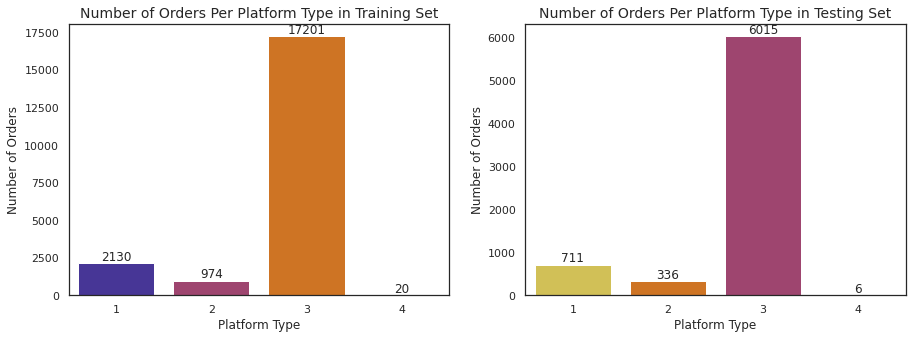

In [21]:
# Number of Orders Per Platform Type
fig,axis = plt.subplots(ncols=2, figsize=(15, 5))

# Training set
ax1_PT = sns.countplot(x='Platform Type',data=train_data,palette='CMRmap',ax=axis[0])
axis[0].set_title('Number of Orders Per Platform Type in Training Set',fontsize=14)
axis[0].set_xlabel('Platform Type')
axis[0].set_ylabel('Number of Orders')
for p in ax1_PT.patches:
    ax1_PT.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')
# Testing set
ax2_PT = sns.countplot(x='Platform Type',data=test_data,palette='CMRmap_r',ax=axis[1])
axis[1].set_title('Number of Orders Per Platform Type in Testing Set',fontsize=14)
axis[1].set_xlabel('Platform Type')
axis[1].set_ylabel('Number of Orders')
for p in ax2_PT.patches:
    ax2_PT.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')

plt.show()

Orders are concentrated on Platform 3 in both the Training set and Testing set, making up approximately 85% of orders in both datasets.

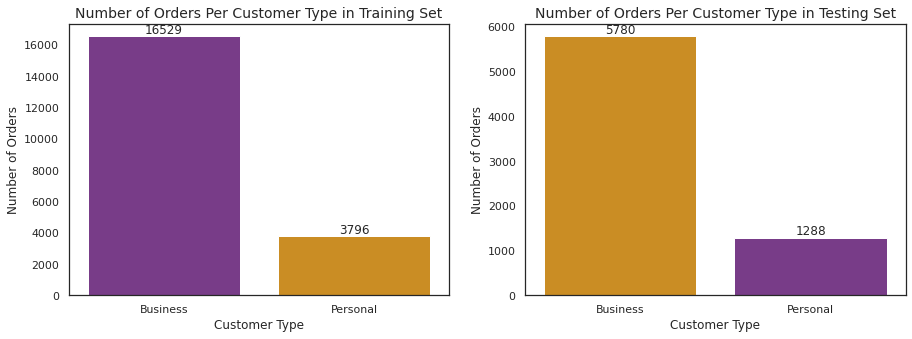

In [22]:
# Number of Orders Per Customer Type
fig,axis = plt.subplots(ncols=2, figsize=(15, 5))

# Training set
ax1_CT = sns.countplot(x='Personal or Business',data=train_data,palette='CMRmap',ax=axis[0])
axis[0].set_title('Number of Orders Per Customer Type in Training Set',fontsize=14)
axis[0].set_xlabel('Customer Type')
axis[0].set_ylabel('Number of Orders')
for p in ax1_CT.patches:
    ax1_CT.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')
# Testing set
ax2_CT = sns.countplot(x='Personal or Business',data=test_data,palette='CMRmap_r',ax=axis[1])
axis[1].set_title('Number of Orders Per Customer Type in Testing Set',fontsize=14)
axis[1].set_xlabel('Customer Type')
axis[1].set_ylabel('Number of Orders')
for p in ax2_CT.patches:
    ax2_CT.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')

plt.show()

Orders are made most by Business customers, 81.32% in the Training set and 81.78% in the Testing set.

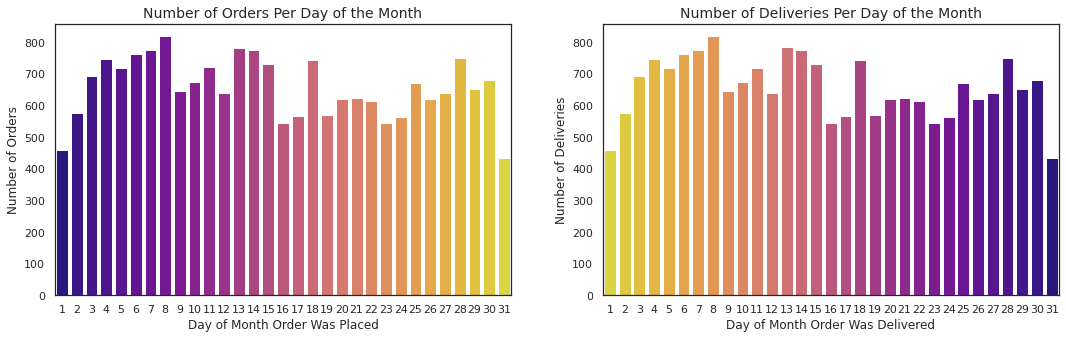

In [23]:
# Number of Orders and Deliveries Per Day of the Month
fig,axis = plt.subplots(ncols=2, figsize=(18, 5))

# Orders
sns.countplot(x='Placement - Day of Month',data=train_data,palette='plasma',ax=axis[0])
axis[0].set_title('Number of Orders Per Day of the Month',fontsize=14)
axis[0].set_xlabel('Day of Month Order Was Placed')
axis[0].set_ylabel('Number of Orders')
# Deliveries
sns.countplot(x='Arrival at Destination - Day of Month',data=train_data,palette='plasma_r',ax=axis[1])
axis[1].set_title('Number of Deliveries Per Day of the Month',fontsize=14)
axis[1].set_xlabel('Day of Month Order Was Delivered')
axis[1].set_ylabel('Number of Deliveries')

plt.show()

Orders seem to be relatively evenly spread out throughout the month, with some decline at the start and in the middle of the month. 'Day of Month' is a cyclical feature and can be converted to a more appropriate format during feature engineering, prior to building our regression model.

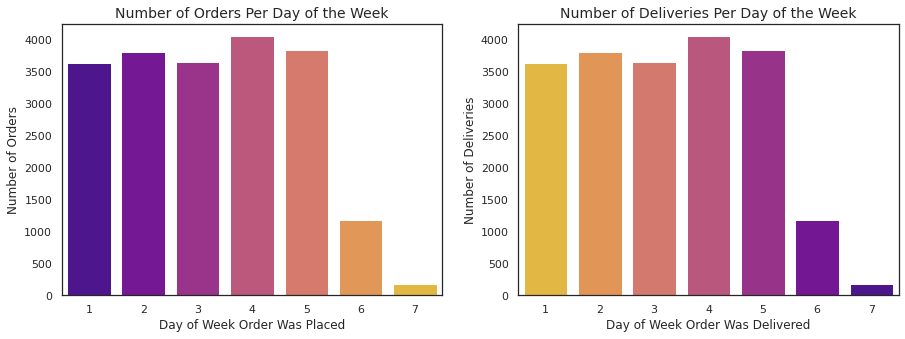

In [24]:
# Number of Orders and Deliveries Per Day of the Week
fig,axis = plt.subplots(ncols=2, figsize=(15, 5))

# Orders
sns.countplot(x='Placement - Weekday',data=train_data,palette='plasma',ax=axis[0])
axis[0].set_title('Number of Orders Per Day of the Week',fontsize=14)
axis[0].set_xlabel('Day of Week Order Was Placed')
axis[0].set_ylabel('Number of Orders')
# Deliveries
sns.countplot(x='Arrival at Destination - Weekday',data=train_data,palette='plasma_r',ax=axis[1])
axis[1].set_title('Number of Deliveries Per Day of the Week',fontsize=14)
axis[1].set_xlabel('Day of Week Order Was Delivered')
axis[1].set_ylabel('Number of Deliveries')

plt.show()

Most orders are placed and delivered during the week, while fewer are placed or delivered over the weekend. 'Weekday' is a cyclical feature and can be converted to a more appropriate format during feature engineering, prior to building our regression model.

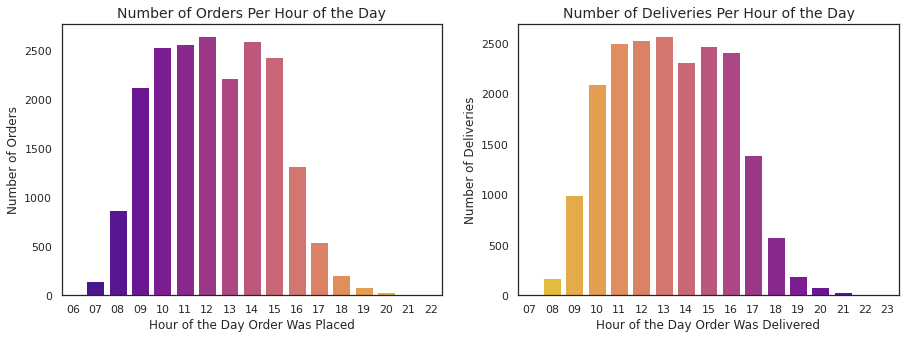

In [25]:
# Distribution of Orders and Deliveries Per Hour of the Day
orders = pd.to_datetime(pd.to_datetime(train_data['Placement - Time']).dt.strftime('%H:%M:%S')).dt.strftime('%H')
deliveries = pd.to_datetime(pd.to_datetime(train_data['Arrival at Destination - Time']).dt.strftime('%H:%M:%S')).dt.strftime('%H')
fig,axis = plt.subplots(ncols=2, figsize=(15, 5))

# Orders
sns.countplot(x=orders,palette='plasma',ax=axis[0])
axis[0].set_title('Number of Orders Per Hour of the Day',fontsize=14)
axis[0].set_xlabel('Hour of the Day Order Was Placed')
axis[0].set_ylabel('Number of Orders')
# Deliveries
sns.countplot(x=deliveries,palette='plasma_r',ax=axis[1])
axis[1].set_title('Number of Deliveries Per Hour of the Day',fontsize=14)
axis[1].set_xlabel('Hour of the Day Order Was Delivered')
axis[1].set_ylabel('Number of Deliveries')

plt.show()

Placement and delivery of orders starts to increase from around 09:00 and decreases again from around 15:00 to 16:00. 'Hour of the Day' is a cyclical feature and can be converted to a more appropriate format during feature engineering, prior to building our regression model.

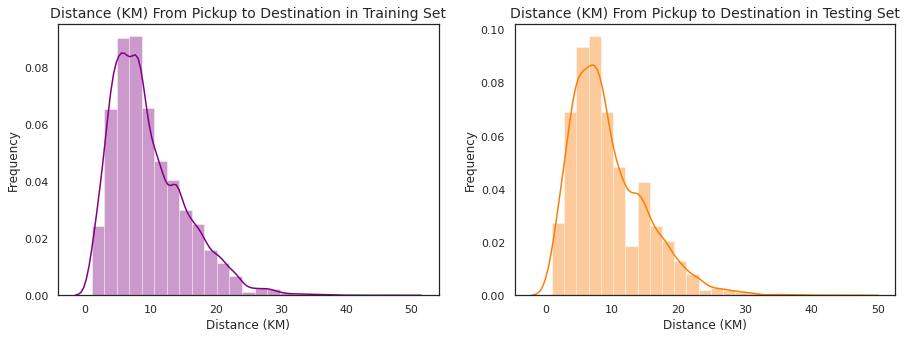

In [26]:
# Distribution of Distance from Pickup to Destination
fig,axis = plt.subplots(ncols=2, figsize=(15, 5))

# Training set
sns.distplot(train_data['Distance (KM)'],bins=25,color='purple',ax=axis[0])
axis[0].set_title('Distance (KM) From Pickup to Destination in Training Set',fontsize=14)
axis[0].set_xlabel('Distance (KM)')
axis[0].set_ylabel('Frequency')
# Testing set
sns.distplot(test_data['Distance (KM)'],bins=25,color='#fb7d07',ax=axis[1])
axis[1].set_title('Distance (KM) From Pickup to Destination in Testing Set',fontsize=14)
axis[1].set_xlabel('Distance (KM)')
axis[1].set_ylabel('Frequency')

plt.show()

Most rides made from pickup to destination are under 20km for both Training set and Testing set. Independent variables that are not normally distributed can be normalised (e.g. log transform) during data preprocessing.

### Bivariate Analysis and Visualisation

In this section we will describe and visualise data that involves two variables:
* Time from Pickup to Arrival Per Platform Type
* Time from Pickup to Arrival Per Customer Type
* Time from Pickup to Arrival Per Day of the Month
* Time from Pickup to Arrival Per Day of the Week
* Time from Pickup to Arrival Per Hour of the Day
* Travel Distance Per Platform Type
* Travel Distance Per Customer Type
* Travel Distance Per Day of the Month
* Travel Distance Per Day of the Week
* Travel Distance Per Hour of the Day

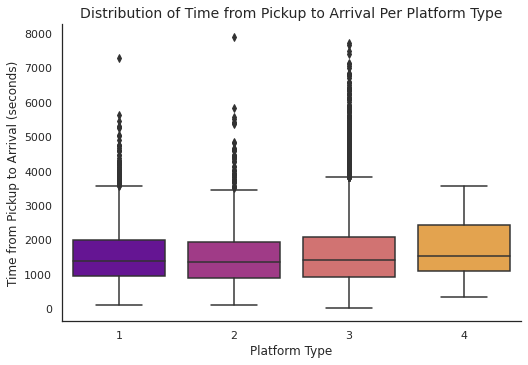

In [27]:
# Time from Pickup to Arrival Per Platform Type
sns.catplot(x='Platform Type', y='Time from Pickup to Arrival',data=train_data.sort_values('Platform Type'),kind='box',height=5,aspect=1.5,palette='plasma')
plt.title('Distribution of Time from Pickup to Arrival Per Platform Type',fontsize=14)
plt.xlabel('Platform Type')
plt.ylabel('Time from Pickup to Arrival (seconds)')

plt.show()

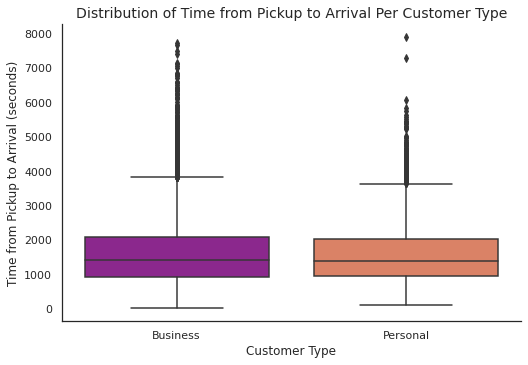

In [28]:
# Time from Pickup to Arrival Per Customer Type
sns.catplot(x='Personal or Business', y='Time from Pickup to Arrival',data=train_data.sort_values('Personal or Business'),kind='box',height=5,aspect=1.5,palette='plasma')
plt.title('Distribution of Time from Pickup to Arrival Per Customer Type',fontsize=14)
plt.xlabel('Customer Type')
plt.ylabel('Time from Pickup to Arrival (seconds)')

plt.show()

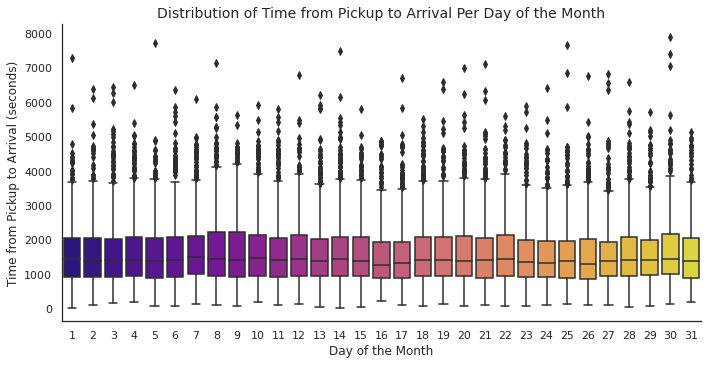

In [29]:
# Time from Pickup to Arrival Per Day of the Month
sns.catplot(x='Arrival at Destination - Day of Month', y='Time from Pickup to Arrival',data=train_data.sort_values('Arrival at Destination - Day of Month'),kind='box',height=5,aspect=2,palette='plasma')
plt.title('Distribution of Time from Pickup to Arrival Per Day of the Month',fontsize=14)
plt.xlabel('Day of the Month')
plt.ylabel('Time from Pickup to Arrival (seconds)')

plt.show()

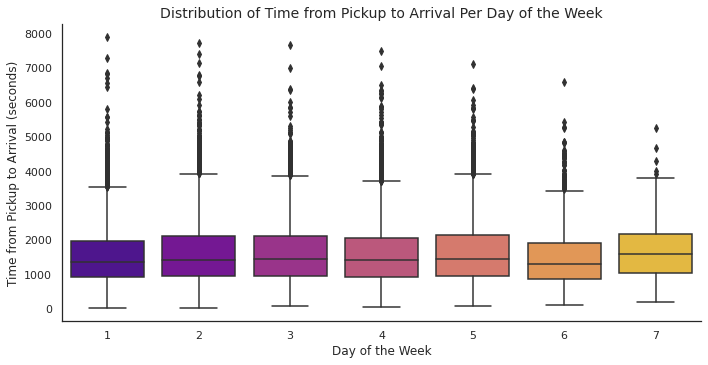

In [30]:
# Time from Pickup to Arrival Per Day of the Week
sns.catplot(x='Arrival at Destination - Weekday', y='Time from Pickup to Arrival',data=train_data.sort_values('Arrival at Destination - Weekday'),kind='box',height=5,aspect=2,palette='plasma')
plt.title('Distribution of Time from Pickup to Arrival Per Day of the Week',fontsize=14)
plt.xlabel('Day of the Week')
plt.ylabel('Time from Pickup to Arrival (seconds)')

plt.show()

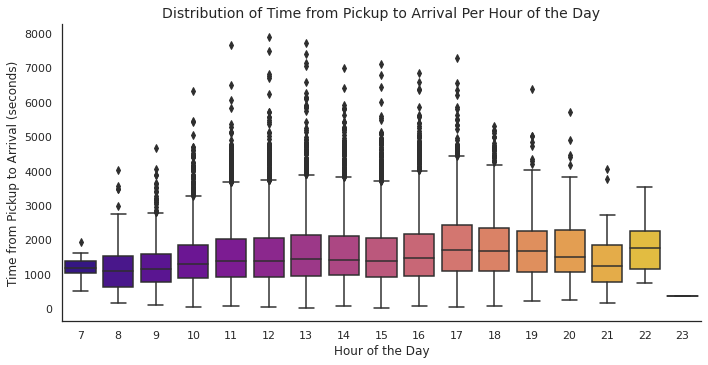

In [31]:
# Time from Pickup to Arrival Per Hour of the Day
order = train_data.sort_values('Arrival at Destination - Time')
order['time'] = pd.to_datetime(pd.to_datetime(train_data['Arrival at Destination - Time']).dt.strftime('%H:%M:%S')).dt.strftime('%H').astype(int)
sns.catplot(x='time', y='Time from Pickup to Arrival',data=order,kind='box',height=5,aspect=2,palette='plasma')
plt.title('Distribution of Time from Pickup to Arrival Per Hour of the Day',fontsize=14)
plt.xlabel('Hour of the Day')
plt.ylabel('Time from Pickup to Arrival (seconds)')

plt.show()

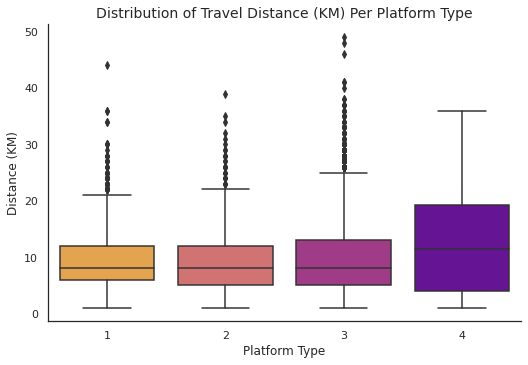

In [32]:
# Travel Distance Per Platform Type
sns.catplot(x='Platform Type', y='Distance (KM)',data=train_data.sort_values('Platform Type'),kind='box',height=5,aspect=1.5,palette='plasma_r')
plt.title('Distribution of Travel Distance (KM) Per Platform Type',fontsize=14)
plt.xlabel('Platform Type')
plt.ylabel('Distance (KM)')
plt.show()

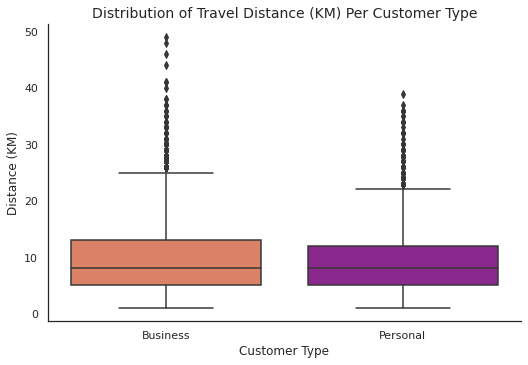

In [33]:
# Travel Distance Per Customer Type
sns.catplot(x='Personal or Business', y='Distance (KM)',data=train_data.sort_values('Personal or Business'),kind='box',height=5,aspect=1.5,palette='plasma_r')
plt.title('Distribution of Travel Distance (KM) Per Customer Type',fontsize=14)
plt.xlabel('Customer Type')
plt.ylabel('Distance (KM)')

plt.show()

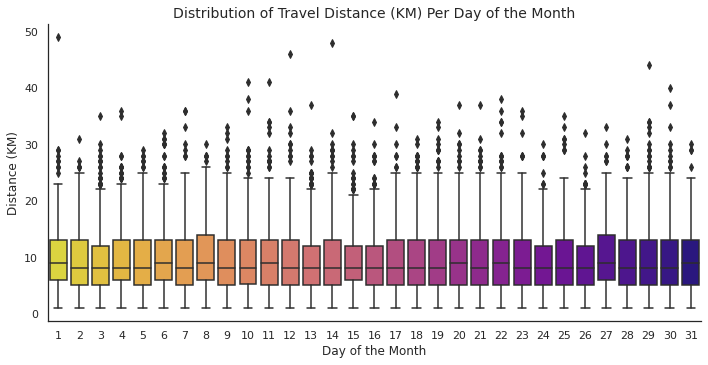

In [34]:
# Travel Distance Per Day of the Month
sns.catplot(x='Arrival at Destination - Day of Month', y='Distance (KM)',data=train_data.sort_values('Arrival at Destination - Day of Month'),kind='box',height=5,aspect=2,palette='plasma_r')
plt.title('Distribution of Travel Distance (KM) Per Day of the Month',fontsize=14)
plt.xlabel('Day of the Month')
plt.ylabel('Distance (KM)')

plt.show()

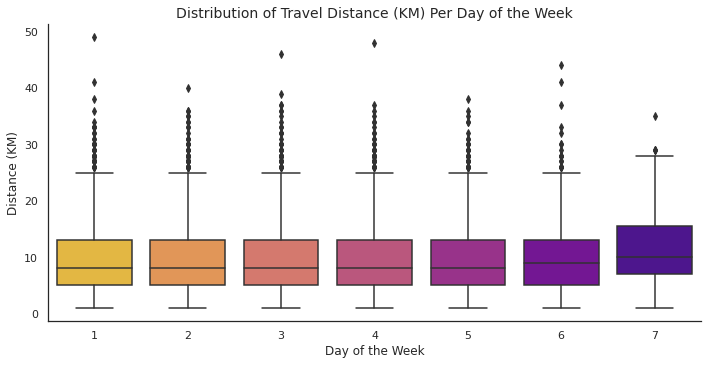

In [35]:
# Travel Distance Per Day of the Week
sns.catplot(x='Arrival at Destination - Weekday', y='Distance (KM)',data=train_data.sort_values('Arrival at Destination - Weekday'),kind='box',height=5,aspect=2,palette='plasma_r')
plt.title('Distribution of Travel Distance (KM) Per Day of the Week',fontsize=14)
plt.xlabel('Day of the Week')
plt.ylabel('Distance (KM)')

plt.show()

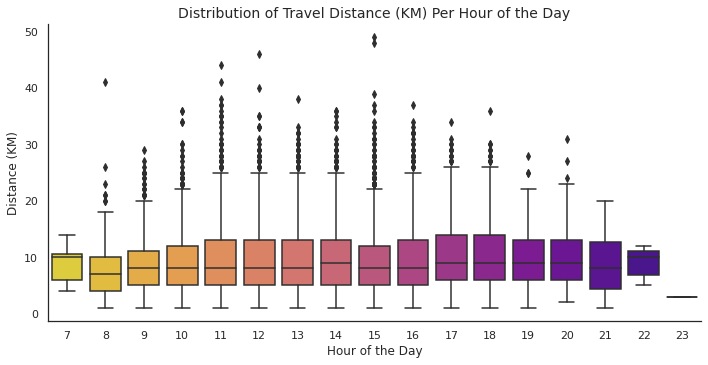

In [36]:
# Travel Distance Per Hour of the Day
sns.catplot(x='time', y='Distance (KM)',data=order,kind='box',height=5,aspect=2,palette='plasma_r')
plt.title('Distribution of Travel Distance (KM) Per Hour of the Day',fontsize=14)
plt.xlabel('Hour of the Day')
plt.ylabel('Distance (KM)')

plt.show()

<a id="preprocessing"></a>
## 5. Data Preprocessing

### Feature Engineering

**Ranking Riders:**  
We can combine features from the riders dataset to better rank each rider, based on their average delivery rate and an average rating that is scaled according to the number of ratings they have received in proportion to the whole dataset.

In [39]:
# Calculate delivery rate for riders 
train_data['Delivery Rate'] = train_data['No of Orders']/train_data['Age']
test_data['Delivery Rate'] = test_data['No of Orders']/test_data['Age']

# Calculate scaled rating for riders
train_data['Scaled Rating'] = train_data['Average Rating']*(train_data['No of Ratings']/train_data['No of Ratings'].sum())
test_data['Scaled Rating'] = test_data['Average Rating']*(test_data['No of Ratings']/test_data['No of Ratings'].sum())

**Encoding Date/Time Features:**  
Date and time features (such as day of month, day of week, and time of day) are cyclical features that need to be represented in a way where the circular information isn't lost (e.g. that the hour 23:00 and the hour 01:00 are the same distance from midnight). To do this, we can represent each feature as coordinates on a circle using **_sin_** and **_cos_** trigonometric functions.

More information can be found here:  
https://medium.com/ai%C2%B3-theory-practice-business/top-6-errors-novice-machine-learning-engineers-make-e82273d394db  
http://blog.davidkaleko.com/feature-engineering-cyclical-features.html  
https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning  
https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/  

In [40]:
# Convert pickup day of month feature to cyclical format
train_data['Pickup - Day of Month (sin)'] = np.sin((train_data['Pickup - Day of Month'])*(2.*np.pi/31))
train_data['Pickup - Day of Month (cos)'] = np.cos((train_data['Pickup - Day of Month'])*(2.*np.pi/31))
test_data['Pickup - Day of Month (sin)'] = np.sin((test_data['Pickup - Day of Month'])*(2.*np.pi/31))
test_data['Pickup - Day of Month (cos)'] = np.cos((test_data['Pickup - Day of Month'])*(2.*np.pi/31))

# Convert pickup weekday feature to cyclical format
train_data['Pickup - Weekday (sin)'] = np.sin(train_data['Pickup - Weekday']*(2.*np.pi/7))
train_data['Pickup - Weekday (cos)'] = np.cos(train_data['Pickup - Weekday']*(2.*np.pi/7))
test_data['Pickup - Weekday (sin)'] = np.sin(test_data['Pickup - Weekday']*(2.*np.pi/7))
test_data['Pickup - Weekday (cos)'] = np.cos(test_data['Pickup - Weekday']*(2.*np.pi/7))

# Function to calculate time in seconds (from midnight)
def time_in_seconds(df,column):
    df[column] = pd.to_datetime(df[column])
    return (df[column] - pd.to_datetime(pd.to_datetime('today').date())).astype('timedelta64[s]')

# Convert pickup time feature to cyclical format
train_data['Pickup - Time'] = time_in_seconds(train_data,'Pickup - Time')
test_data['Pickup - Time'] = time_in_seconds(test_data,'Pickup - Time')
train_data['Pickup - Time (sin)'] = np.sin(train_data['Placement - Time(bins)'].astype('int64')*(2.*np.pi/24))
train_data['Pickup - Time (cos)'] = np.cos(train_data['Placement - Time(bins)'].astype('int64')*(2.*np.pi/24))
test_data['Pickup - Time (sin)'] = np.sin(test_data['Placement - Time(bins)'].astype('int64')*(2.*np.pi/24))
test_data['Pickup - Time (cos)'] = np.cos(test_data['Placement - Time(bins)'].astype('int64')*(2.*np.pi/24))

**Visualising cyclical features:** An intuitive way to visualise how the cyclical data is now represented, is to plot the two new transformed features in 2D, the same way as we would plot time on a 24-hour clock. The distance between two points corresponds to the difference in time as we expect from a 24-hour cycle.

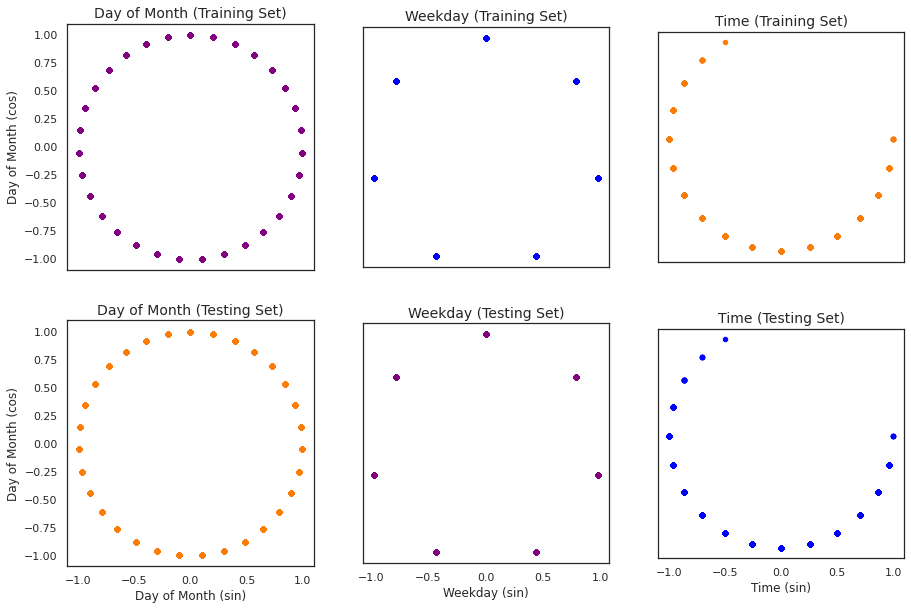

In [41]:
# Cyclical features
fig,((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

# Training set
# Day of month
train_data.plot.scatter('Pickup - Day of Month (sin)','Pickup - Day of Month (cos)',ax=ax1,color='purple').set_aspect('equal')
ax1.set_title('Day of Month (Training Set)',fontsize=14)
ax1.set_xlabel('Day of Month (sin)')
ax1.set_ylabel('Day of Month (cos)')
# Weekday
train_data.plot.scatter('Pickup - Weekday (sin)','Pickup - Weekday (cos)',ax=ax2,color='blue').set_aspect('equal')
ax2.set_title('Weekday (Training Set)',fontsize=14)
ax2.set_xlabel('Weekday (sin)')
ax2.set_ylabel('Weekday (cos)')
# Time
train_data.plot.scatter('Pickup - Time (sin)','Pickup - Time (cos)',ax=ax3,color='#fb7d07').set_aspect('equal')
ax3.set_title('Time (Training Set)',fontsize=14)
ax3.set_xlabel('Time (sin)')
ax3.set_ylabel('Time (cos)')

# Testing set
# Day of month
test_data.plot.scatter('Pickup - Day of Month (sin)','Pickup - Day of Month (cos)',ax=ax4,color='#fb7d07').set_aspect('equal')
ax4.set_title('Day of Month (Testing Set)',fontsize=14)
ax4.set_xlabel('Day of Month (sin)')
ax4.set_ylabel('Day of Month (cos)')
# Weekday
test_data.plot.scatter('Pickup - Weekday (sin)','Pickup - Weekday (cos)',ax=ax5,color='purple').set_aspect('equal')
ax5.set_title('Weekday (Testing Set)',fontsize=14)
ax5.set_xlabel('Weekday (sin)')
ax5.set_ylabel('Weekday (cos)')
# Time
test_data.plot.scatter('Pickup - Time (sin)','Pickup - Time (cos)',ax=ax6,color='blue').set_aspect('equal')
ax6.set_title('Time (Testing Set)',fontsize=14)
ax6.set_xlabel('Time (sin)')
ax6.set_ylabel('Time (cos)')

for ax in fig.get_axes():
    ax.label_outer()
    
plt.show()

**Convert Coordinates to Geohash Encoding:**  
We can group pickup and destination coordinates into larger areas through geohash encoding. For each location, the latitude and longitude is combined into a short string of letters (geohash) that represents a geographical location. The longer the string, the more precise the location. We then encode these geohash strings as numeric labels in the training set. If a geohash in the testing set matches one in the training set, it is assigned the same label. However, if a geohash in the testing set is not also present in the training set, it is assigned a value of zero.

In [42]:
# Convert coordinates to geohash encoding
train_data['Pickup (geohash)'] = train_data.apply(lambda x: gh.encode(x['Pickup Lat'], x['Pickup Long'], precision=5), axis=1)
train_data['Destination (geohash)'] = train_data.apply(lambda x: gh.encode(x['Destination Lat'], x['Destination Long'], precision=5), axis=1)
test_data['Pickup (geohash)'] = test_data.apply(lambda x: gh.encode(x['Pickup Lat'], x['Pickup Long'], precision=5), axis=1)
test_data['Destination (geohash)'] = test_data.apply(lambda x: gh.encode(x['Destination Lat'], x['Destination Long'], precision=5), axis=1)

# Encode geohash labels in training set
encoder_dict = collections.defaultdict(LabelEncoder)
labeled_df = train_data[['Pickup (geohash)','Destination (geohash)']].apply(lambda x: encoder_dict[x.name].fit_transform(x))
train_data['Pickup (label)'] = labeled_df['Pickup (geohash)']
train_data['Destination (label)'] = labeled_df['Destination (geohash)']

# Create label dictionaries from training set
train_data[['Pickup (label)','Destination (label)']] += 1
pickup_labels = pd.Series(train_data['Pickup (label)'].values,index=train_data['Pickup (geohash)']).to_dict()
destination_labels = pd.Series(train_data['Destination (label)'].values,index=train_data['Destination (geohash)']).to_dict()

# Encode geohash labels in testing set
test_data['Pickup (label)'] = test_data['Pickup (geohash)'].apply(lambda i: pickup_labels[i] if i in pickup_labels.keys() else 0)
test_data['Destination (label)'] = test_data['Destination (geohash)'].apply(lambda i: destination_labels[i] if i in destination_labels.keys() else 0)

Geohash encoding these coordinates allows us to determine the number of pickup locations or destinations there are within a particular area.

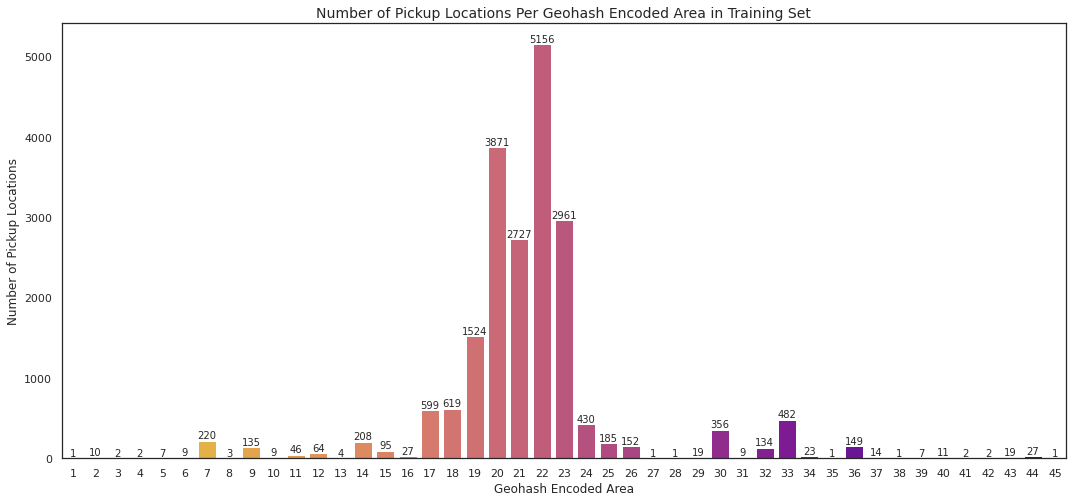

In [43]:
# Number of Pickup Locations Per Geohash Encoded Area in Training Set
fig,axis = plt.subplots(figsize=(18, 8))
ax_geoP = sns.countplot(x='Pickup (label)',data=train_data,palette='plasma_r')
plt.title('Number of Pickup Locations Per Geohash Encoded Area in Training Set',fontsize=14)
plt.xlabel('Geohash Encoded Area')
plt.ylabel('Number of Pickup Locations')
for p in ax_geoP.patches:
    ax_geoP.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=10, ha='center', va='bottom')

plt.show()

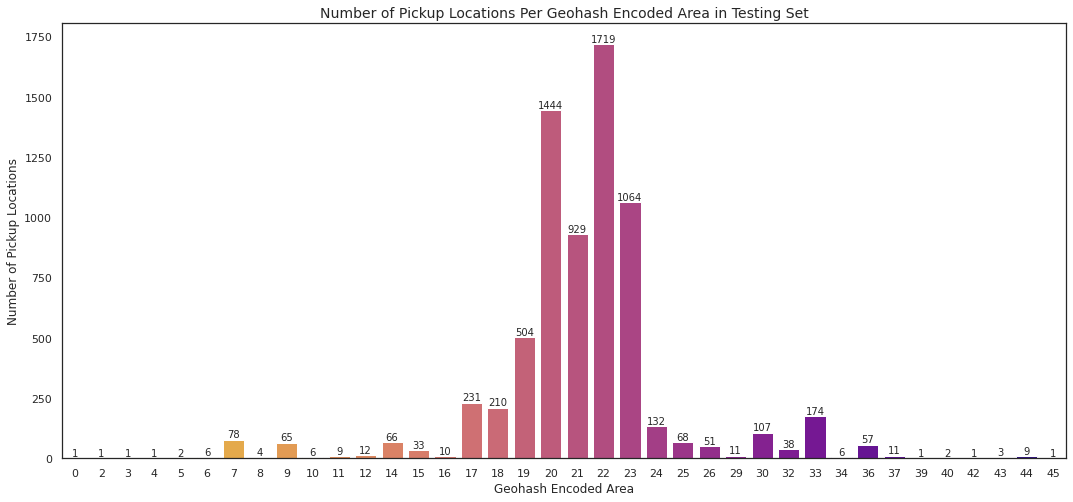

In [44]:
# Number of Pickup Locations Per Geohash Encoded Area in Testing Set
fig,axis = plt.subplots(figsize=(18, 8))
ax_geoP = sns.countplot(x='Pickup (label)',data=test_data,palette='plasma_r')
plt.title('Number of Pickup Locations Per Geohash Encoded Area in Testing Set',fontsize=14)
plt.xlabel('Geohash Encoded Area')
plt.ylabel('Number of Pickup Locations')
for p in ax_geoP.patches:
    ax_geoP.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=10, ha='center', va='bottom')

plt.show()

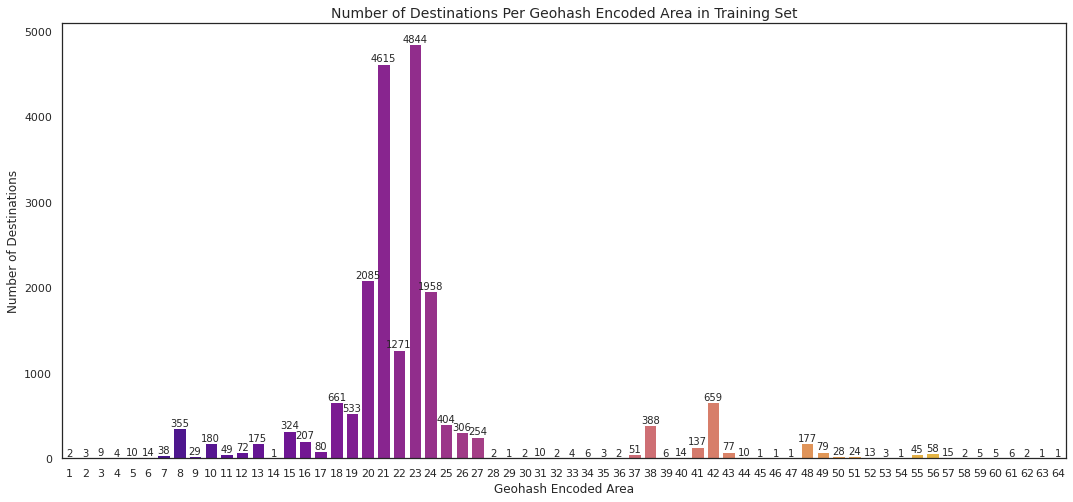

In [45]:
# Number of Destinations Per Geohash Encoded Area in Training Set
fig,axis = plt.subplots(figsize=(18, 8))
ax_geoP = sns.countplot(x='Destination (label)',data=train_data,palette='plasma')
plt.title('Number of Destinations Per Geohash Encoded Area in Training Set',fontsize=14)
plt.xlabel('Geohash Encoded Area')
plt.ylabel('Number of Destinations')
for p in ax_geoP.patches:
    ax_geoP.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=10, ha='center', va='bottom')

plt.show()

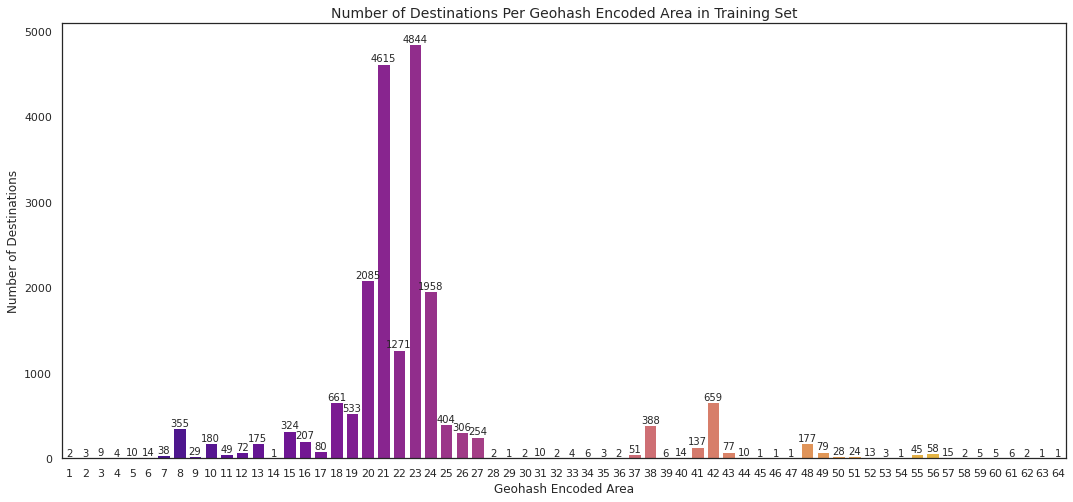

In [46]:
# Number of Destinations Per Geohash Encoded Area in Training Set
fig,axis = plt.subplots(figsize=(18, 8))
ax_geoP = sns.countplot(x='Destination (label)',data=train_data,palette='plasma')
plt.title('Number of Destinations Per Geohash Encoded Area in Training Set',fontsize=14)
plt.xlabel('Geohash Encoded Area')
plt.ylabel('Number of Destinations')
for p in ax_geoP.patches:
    ax_geoP.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=10, ha='center', va='bottom')

plt.show()

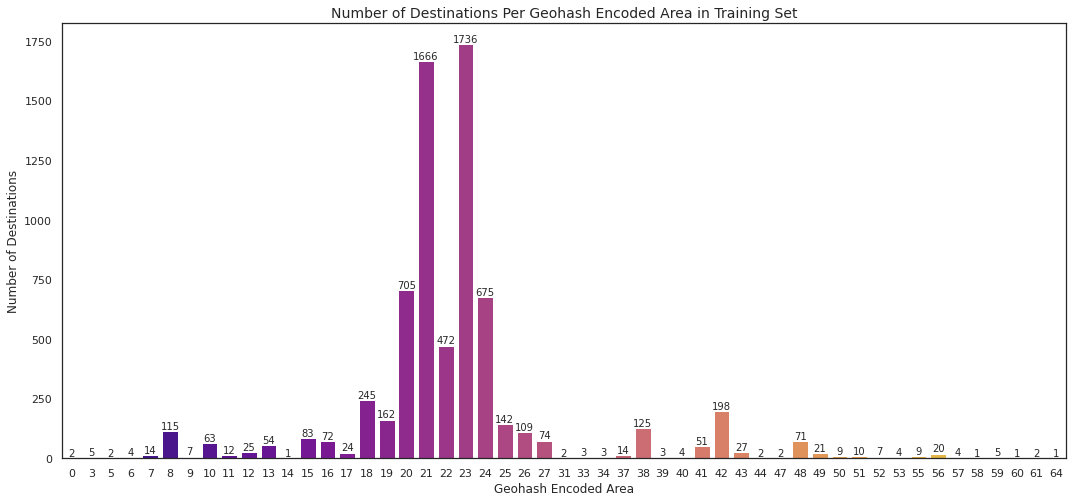

In [47]:
# Number of Destinations Per Geohash Encoded Area in Testing Set
fig,axis = plt.subplots(figsize=(18, 8))
ax_geoP = sns.countplot(x='Destination (label)',data=test_data,palette='plasma')
plt.title('Number of Destinations Per Geohash Encoded Area in Training Set',fontsize=14)
plt.xlabel('Geohash Encoded Area')
plt.ylabel('Number of Destinations')
for p in ax_geoP.patches:
    ax_geoP.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=10, ha='center', va='bottom')

plt.show()

**Transforming the Target (Dependent) Variable:**  
One of the most important assumptions for statistical tests and regression is the assumption of normality. Non-normal dependent variables can be transformed to a normal shape through a Box Cox transformation. By normalising our data, we are able to perform a much broader number of tests.  
(Source: https://www.statisticshowto.com/box-cox-transformation/)

Outliers in normally distributed variables can be removed based on their Z-score values. Generally, a threshold of 3 or -3 is used (i.e if the Z-score value is greater than 3 or less than -3, that data point will be identified as an outlier).  
(Source: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)

In [48]:
# Transform target variable and remove high zscores
train_data_t = train_data.copy()
train_data_t['transformed'] = boxcox(train_data['Time from Pickup to Arrival'])[0]
train_data_t['zscore'] = zscore(train_data_t['transformed'])
train_data_t = train_data_t[train_data_t['zscore'].abs() < 3]
train_data_t = train_data_t.drop('zscore', axis=1)
print(str(len(train_data)-len(train_data_t)) + " additional outliers were removed")

73 additional outliers were removed


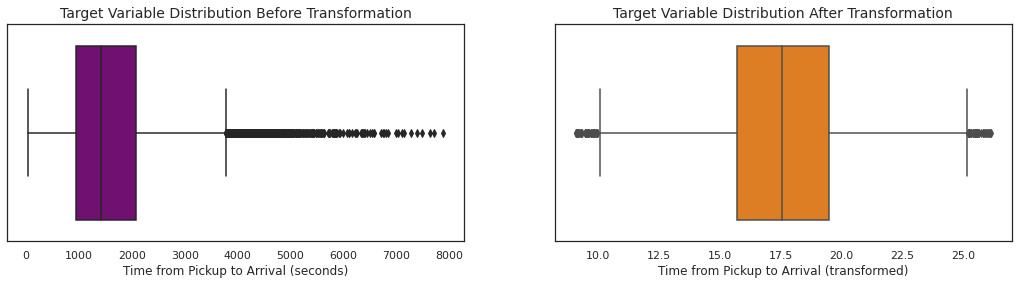

In [49]:
# Distribution of Distance from Pickup to Destination
fig,axis = plt.subplots(ncols=2, figsize=(18, 4))

# Before
sns.boxplot(x=train_data['Time from Pickup to Arrival'],color='purple',ax=axis[0])
axis[0].set_title('Target Variable Distribution Before Transformation',fontsize=14)
axis[0].set_xlabel('Time from Pickup to Arrival (seconds)')
# After
sns.boxplot(x=train_data_t['transformed'],color='#fb7d07',ax=axis[1])
axis[1].set_title('Target Variable Distribution After Transformation',fontsize=14)
axis[1].set_xlabel('Time from Pickup to Arrival (transformed)')

plt.show()

**Transforming the Independent (Predictor) Variables:**  The following three non-normal/skewed features were normalised through a log transform
* Distance (KM)
* Age
* No of Orders

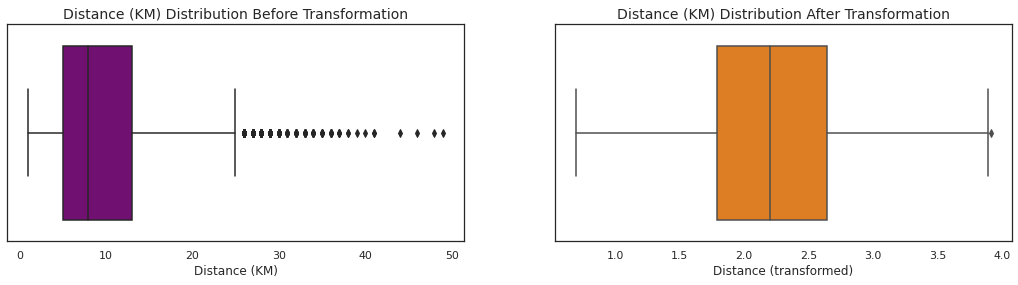

In [50]:
### Distance
fig,axis = plt.subplots(ncols=2, figsize=(18, 4))

# Before
sns.boxplot(x=train_data['Distance (KM)'],color='purple',ax=axis[0])
axis[0].set_title('Distance (KM) Distribution Before Transformation',fontsize=14)
axis[0].set_xlabel('Distance (KM)')
# After
sns.boxplot(x=np.log1p(train_data['Distance (KM)']),color='#fb7d07',ax=axis[1])
axis[1].set_title('Distance (KM) Distribution After Transformation',fontsize=14)
axis[1].set_xlabel('Distance (transformed)')

train_data_t['Distance (KM)'] = np.log1p(train_data['Distance (KM)'])
test_data['Distance (KM)'] = np.log1p(test_data['Distance (KM)'])

plt.show()

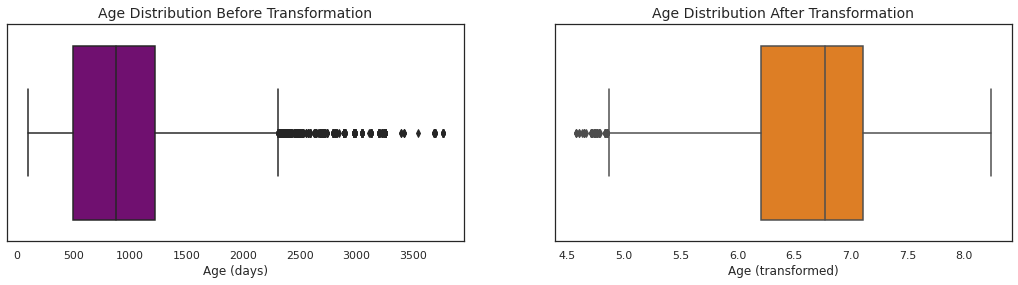

In [51]:
### Age
fig,axis = plt.subplots(ncols=2, figsize=(18, 4))

# Before
sns.boxplot(x=train_data['Age'],color='purple',ax=axis[0])
axis[0].set_title('Age Distribution Before Transformation',fontsize=14)
axis[0].set_xlabel('Age (days)')
# After
sns.boxplot(x=np.log1p(train_data['Age']),color='#fb7d07',ax=axis[1])
axis[1].set_title('Age Distribution After Transformation',fontsize=14)
axis[1].set_xlabel('Age (transformed)')

train_data_t['Age'] = np.log1p(train_data['Age'])
test_data['Age'] = np.log1p(test_data['Age'])

plt.show()

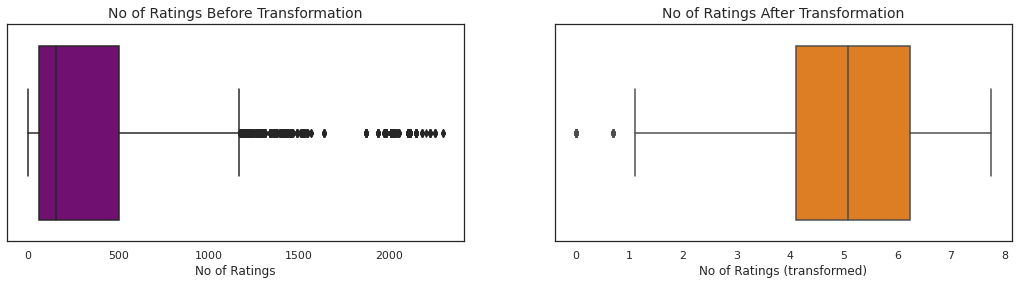

In [52]:
### No of Ratings
fig,axis = plt.subplots(ncols=2, figsize=(18, 4))

# Before
sns.boxplot(x=train_data['No of Ratings'],color='purple',ax=axis[0])
axis[0].set_title('No of Ratings Before Transformation',fontsize=14)
axis[0].set_xlabel('No of Ratings')
# After
sns.boxplot(x=np.log1p(train_data['No of Ratings']),color='#fb7d07',ax=axis[1])
axis[1].set_title('No of Ratings After Transformation',fontsize=14)
axis[1].set_xlabel('No of Ratings (transformed)')

train_data_t['No of Ratings'] = np.log1p(train_data['No of Ratings'])
test_data['No of Ratings'] = np.log1p(test_data['No of Ratings'])

plt.show()

### Encoding Categorical Data

Feature encoding is the process of converting categorical variables to continuous variables. This is important because most machine learning algorithms perform better when all the variables are in a numerical format. We have two variables which are categorical, "Platform Type" and "Personal or Business". We changed "Platform Type" from an integer into a string so that we can encode it in order to avoid the algorithms interpreting the variable as numerical data. We used Label encoding and One Hot encoding to transform these two variables. Label encoding converts a categorical value into a number which is unique to that value. One Hot encoding takes a columnn which has been label encoded and splits it into multiple columns, each number containing a 0 or 1.

In [53]:
# Change 'Platform Type' data type
train_data_t['Platform Type'] = train_data_t['Platform Type'].astype(str)

# Check how many unique items are in each column of indepedent variables
for col_name in train_data_t.columns:
    if train_data_t[col_name].dtypes=='object':
        unique_out = len(train_data_t[col_name].unique())
        print(f"Feature '{col_name}' has {unique_out} unique catergories")

Feature 'Order No' has 20252 unique catergories
Feature 'User Id' has 3169 unique catergories
Feature 'Vehicle Type' has 1 unique catergories
Feature 'Platform Type' has 4 unique catergories
Feature 'Personal or Business' has 2 unique catergories
Feature 'Placement - Time' has 15182 unique catergories
Feature 'Confirmation - Time' has 15220 unique catergories
Feature 'Arrival at Pickup - Time' has 15231 unique catergories
Feature 'Arrival at Destination - Time' has 15182 unique catergories
Feature 'Rider Id' has 921 unique catergories
Feature 'Placement - Time(bins)' has 17 unique catergories
Feature 'Pickup (geohash)' has 45 unique catergories
Feature 'Destination (geohash)' has 64 unique catergories


In [54]:
# Change 'Platform Type' data type
test_data['Platform Type'] = test_data['Platform Type'].astype(str)

# Check how many unique items are in each column of indepedent variables
for col_name in test_data.columns:
    if test_data[col_name].dtypes=='object':
        unique_out = len(test_data[col_name].unique())
        print(f"Feature '{col_name}' has {unique_out} unique catergories")

Feature 'Order No' has 7068 unique catergories
Feature 'User Id' has 1617 unique catergories
Feature 'Vehicle Type' has 1 unique catergories
Feature 'Platform Type' has 4 unique catergories
Feature 'Personal or Business' has 2 unique catergories
Feature 'Placement - Time' has 6336 unique catergories
Feature 'Confirmation - Time' has 6388 unique catergories
Feature 'Arrival at Pickup - Time' has 6374 unique catergories
Feature 'Rider Id' has 822 unique catergories
Feature 'Placement - Time(bins)' has 17 unique catergories
Feature 'Pickup (geohash)' has 38 unique catergories
Feature 'Destination (geohash)' has 52 unique catergories


In [55]:
all_features = ['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday', 'Arrival at Destination - Time',
       'Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id', 'No of Orders',
       'Age', 'Average Rating', 'No of Ratings', 'Placement - Time(bins)',
       'Delivery Rate', 'Scaled Rating', 'Pickup - Day of Month (sin)',
       'Pickup - Day of Month (cos)', 'Pickup - Weekday (sin)',
       'Pickup - Weekday (cos)', 'Pickup - Time (sin)', 'Pickup - Time (cos)',
       'Pickup (geohash)', 'Destination (geohash)', 'Pickup (label)',
       'Destination (label)', 'Time from Pickup to Arrival']

model_features = ['Platform Type','Personal or Business',
       'Pickup - Day of Month', 'Pickup - Weekday', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'No of Orders',
       'Age', 'Average Rating', 'No of Ratings', 'Delivery Rate', 'Scaled Rating', 
       'Pickup - Day of Month (sin)', 'Pickup - Day of Month (cos)',
       'Pickup - Weekday (sin)', 'Pickup - Weekday (cos)', 'Pickup - Time (sin)', 
       'Pickup - Time (cos)', 'Pickup (label)', 'Destination (label)', 
       'Time from Pickup to Arrival']

In [56]:
# Drop unnecessary columns
train = train_data_t[model_features]
test = test_data[model_features[:-1]]

# Rearrange columns
train['Time from Pickup to Arrival'] = train.pop('Time from Pickup to Arrival')
train.head()

,Platform Type,Personal or Business,Pickup - Day of Month,Pickup - Weekday,Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No of Orders,Age,Average Rating,No of Ratings,Delivery Rate,Scaled Rating,Pickup - Day of Month (sin),Pickup - Day of Month (cos),Pickup - Weekday (sin),Pickup - Weekday (cos),Pickup - Time (sin),Pickup - Time (cos),Pickup (label),Destination (label),Time from Pickup to Arrival
0,3,Business,9,5,37650.0,1.609438,20.4,-1.317755,36.830370,-1.300406,36.829741,1637,7.177782,13.8,6.309918,1.250573,0.001095,0.968077,-0.250653,-0.974928,-0.222521,7.071068e-01,-0.707107,23,24,745
1,3,Personal,12,5,42249.0,2.833213,26.4,-1.351453,36.899315,-1.295004,36.814358,396,5.828946,13.6,4.248495,1.168142,0.000136,0.651372,-0.758758,-0.974928,-0.222521,2.588190e-01,-0.965926,18,21,1993
2,3,Business,30,2,46383.0,1.386294,23.5,-1.308284,36.843419,-1.300921,36.828195,1023,5.493061,12.5,4.744932,4.227273,0.000206,-0.201299,0.979530,0.974928,-0.222521,1.224647e-16,-1.000000,23,24,455
3,3,Business,15,5,34986.0,2.302585,19.2,-1.281301,36.832396,-1.257147,36.795063,886,5.648974,14.5,4.736198,3.130742,0.000237,0.101168,-0.994869,-0.974928,-0.222521,7.071068e-01,-0.707107,23,23,1341
4,1,Personal,13,1,36323.0,2.302585,15.4,-1.266597,36.792118,-1.295041,36.809817,2311,6.771936,14.1,6.280396,2.650229,0.001086,0.485302,-0.874347,0.781831,0.623490,7.071068e-01,-0.707107,22,21,1214


In [57]:
test.head()

,Platform Type,Personal or Business,Pickup - Day of Month,Pickup - Weekday,Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No of Orders,Age,Average Rating,No of Ratings,Delivery Rate,Scaled Rating,Pickup - Day of Month (sin),Pickup - Day of Month (cos),Pickup - Weekday (sin),Pickup - Weekday (cos),Pickup - Time (sin),Pickup - Time (cos),Pickup (label),Destination (label)
0,3,Business,27,3,61607.0,2.197225,19.2,-1.333275,36.870815,-1.305249,36.822390,439,7.321189,13.3,5.147494,0.290536,0.000939,-0.724793,0.688967,0.433884,-0.900969,-8.660254e-01,-0.500000,18,21
1,3,Business,17,5,48337.0,1.791759,23.3,-1.272639,36.794723,-1.277007,36.823907,488,5.613128,14.4,3.828641,1.787546,0.000267,-0.299363,-0.954139,-0.974928,-0.222521,1.224647e-16,-1.000000,22,21
2,3,Business,27,4,43074.0,1.791759,22.8,-1.290894,36.822971,-1.276574,36.851365,833,6.133398,13.1,4.219508,1.810870,0.000362,-0.724793,0.688967,-0.433884,-0.900969,2.588190e-01,-0.965926,20,24
3,3,Business,17,1,51412.0,1.791759,24.5,-1.290503,36.809646,-1.303382,36.790658,487,6.329721,13.7,3.806662,0.869643,0.000249,-0.299363,-0.954139,0.781831,0.623490,-2.588190e-01,-0.965926,20,21
4,3,Business,11,2,42964.0,1.945910,24.4,-1.281081,36.814423,-1.266467,36.792161,4761,7.021976,14.1,6.918695,4.250893,0.005877,0.790776,-0.612106,0.974928,-0.222521,2.588190e-01,-0.965926,20,23


We separate independent variables from the dependent variable (target) by creating a matrix of features. We encode the categorical data to make them continuous data so that we can fit them to the model.

In [58]:
# Create matrix of features
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values
X_test = test.iloc[:,:].values

# Encode categorical data
# Training set
label = LabelEncoder()
X[:,1] = label.fit_transform(X[:,1]) #Customer Type
ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[0])],remainder='passthrough') #Platform Type
X = np.array(ct.fit_transform(X))
# Testing set
X_test[:,1] = label.transform(X_test[:,1]) #Customer Type
X_test = np.array(ct.transform(X_test)) #Platform Type

# Drop last Platform Type dummy variable
X = np.delete(X,3,axis=1)
X_test = np.delete(X_test,3,axis=1)

pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0,0,1,0,9,5,37650,1.60944,20.4,-1.31775,36.8304,-1.30041,36.8297,1637,7.17778,13.8,6.30992,1.25057,0.00109523,0.968077,-0.250653,-0.974928,-0.222521,0.707107,-0.707107,23,24
1,0,0,1,1,12,5,42249,2.83321,26.4,-1.35145,36.8993,-1.295,36.8144,396,5.82895,13.6,4.2485,1.16814,0.000135657,0.651372,-0.758758,-0.974928,-0.222521,0.258819,-0.965926,18,21
2,0,0,1,0,30,2,46383,1.38629,23.5,-1.30828,36.8434,-1.30092,36.8282,1023,5.49306,12.5,4.74493,4.22727,0.000206001,-0.201299,0.97953,0.974928,-0.222521,1.22465e-16,-1,23,24
3,0,0,1,0,15,5,34986,2.30259,19.2,-1.2813,36.8324,-1.25715,36.7951,886,5.64897,14.5,4.7362,3.13074,0.000236865,0.101168,-0.994869,-0.974928,-0.222521,0.707107,-0.707107,23,23
4,1,0,0,1,13,1,36323,2.30259,15.4,-1.2666,36.7921,-1.29504,36.8098,2311,6.77194,14.1,6.2804,2.65023,0.00108643,0.485302,-0.874347,0.781831,0.62349,0.707107,-0.707107,22,21


In [59]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0,0,1,0,27,3,61607,2.19722,19.2,-1.33327,36.8708,-1.30525,36.8224,439,7.32119,13.3,5.14749,0.290536,0.000938621,-0.724793,0.688967,0.433884,-0.900969,-0.866025,-0.5,18,21
1,0,0,1,0,17,5,48337,1.79176,23.3,-1.27264,36.7947,-1.27701,36.8239,488,5.61313,14.4,3.82864,1.78755,0.000267435,-0.299363,-0.954139,-0.974928,-0.222521,1.22465e-16,-1,22,21
2,0,0,1,0,27,4,43074,1.79176,22.8,-1.29089,36.823,-1.27657,36.8514,833,6.1334,13.1,4.21951,1.81087,0.000362234,-0.724793,0.688967,-0.433884,-0.900969,0.258819,-0.965926,20,24
3,0,0,1,0,17,1,51412,1.79176,24.5,-1.2905,36.8096,-1.30338,36.7907,487,6.32972,13.7,3.80666,0.869643,0.00024878,-0.299363,-0.954139,0.781831,0.62349,-0.258819,-0.965926,20,21
4,0,0,1,0,11,2,42964,1.94591,24.4,-1.28108,36.8144,-1.26647,36.7922,4761,7.02198,14.1,6.9187,4.25089,0.00587737,0.790776,-0.612106,0.974928,-0.222521,0.258819,-0.965926,20,23


### Split Training Set Into Training and Validation Sets

* Training data: Data that contains a known output and the model learns on this data in order to be able to generalize other data later on.
* Validation data: This data is used to assess how well the algorithm was trained with the training data.
* Test data: Data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

print("X_train:", X_train[0,0:11], "... Training")
print("y_train:", y_train[0])
print("X_val:", X_val[0,0:11], "... Validation")
print("y_val:", y_val[0])
print("X_test:", X_test[0,0:11], "... Testing")

X_train: [1.0 0.0 0.0 1 11 5 40578.0 1.9459101490553132 20.9 -1.2921983 36.7965431] ... Training
y_train: 1248
X_val: [0.0 0.0 1.0 1 24 1 54801.0 1.0986122886681096 25.4 -1.26836 36.809632] ... Validation
y_val: 699
X_test: [0.0 0.0 1.0 0 27 3 61607.0 2.1972245773362196 19.2 -1.3332749
 36.870814700000004] ... Testing


### Feature Scaling

Our datasets contain variables with highly varying degrees of magnitude. They comprise values that range from fractional values to values in the thousands. We performed feature scaling using standardisation on the independent variables of the training, validation and test sets. This is the process where the values are standardised within a particular range (a mean of 0 and a standard deviation of 1). Additonally, this process speeds up the performance of some of the algorithms.

In [61]:
# Make new copies for scaling
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Apply scaler to numeric features
sc = StandardScaler()
X_train_scaled[:,4:] = sc.fit_transform(X_train[:,4:])
X_val_scaled[:,4:] = sc.transform(X_val[:,4:])
X_test_scaled[:,4:] = sc.transform(X_test[:,4:])

print("X_train_scaled:", X_train_scaled[0,0:6], "... Training")
print("X_val_scaled:", X_val_scaled[0,0:6], "... Validation")
print("X_test_scaled:", X_test_scaled[0,0:6], "... Testing")

X_train_scaled: [1.0 0.0 0.0 1 -0.5279663120656768 1.1173135783072954] ... Training
X_val_scaled: [0.0 0.0 1.0 1 0.9470435554590739 -1.4338240838950147] ... Validation
X_test_scaled: [0.0 0.0 1.0 0 1.2874304479647856 -0.15825525279385963] ... Testing


### Feature Selection

In [62]:
# Convert to dataframes
all_columns = ['Platform Type 1', 'Platform Type 2','Platform Type 3','Personal or Business', 'Pickup - Day of Month',
       'Pickup - Weekday', 'Pickup - Time', 'Distance (KM)', 'Temperature',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'No of Orders', 'Age', 'Average Rating', 'No of Ratings',
       'Delivery Rate', 'Scaled Rating', 'Pickup - Day of Month (sin)',
       'Pickup - Day of Month (cos)', 'Pickup - Weekday (sin)',
       'Pickup - Weekday (cos)', 'Pickup - Time (sin)', 'Pickup - Time (cos)',
       'Pickup (label)', 'Destination (label)']
# Not scaled
X_train_df = pd.DataFrame(X_train,columns=all_columns)
X_val_df = pd.DataFrame(X_val,columns=all_columns)
X_test_df = pd.DataFrame(X_test,columns=all_columns)
X_all_df = pd.DataFrame(X,columns=all_columns)
# Scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=all_columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled,columns=all_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled,columns=all_columns)
# Convert to numeric
X_train_scaled_df = X_train_scaled_df.apply(pd.to_numeric)
X_val_scaled_df = X_val_scaled_df.apply(pd.to_numeric)
X_test_scaled_df = X_test_scaled_df.apply(pd.to_numeric)
X_train_df = X_train_df.apply(pd.to_numeric)
X_val_df = X_val_df.apply(pd.to_numeric)
X_test_df = X_test_df.apply(pd.to_numeric)
X_all_df = X_all_df.apply(pd.to_numeric)

X_train_scaled_df.head()

,Platform Type 1,Platform Type 2,Platform Type 3,Personal or Business,Pickup - Day of Month,Pickup - Weekday,Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No of Orders,Age,Average Rating,No of Ratings,Delivery Rate,Scaled Rating,Pickup - Day of Month (sin),Pickup - Day of Month (cos),Pickup - Weekday (sin),Pickup - Weekday (cos),Pickup - Time (sin),Pickup - Time (cos),Pickup (label),Destination (label)
0,1.0,0.0,0.0,1,-0.527966,1.117314,-0.821281,-0.509028,-0.688894,-0.354748,-0.390069,0.314000,-0.016346,-0.884725,0.312623,-0.106541,-0.267608,-1.285071,-0.560590,1.047015,-0.854165,-1.402471,0.079538,0.996596,-0.322012,-0.356289,-0.011075
1,0.0,0.0,1.0,0,-0.301042,-1.433824,-0.714119,-0.792420,0.023979,0.658249,-0.616762,0.876769,-0.676966,2.570463,1.539359,-0.329132,1.533863,0.668179,2.191464,0.617998,-1.228499,0.928760,1.504190,0.567409,-0.773030,0.135698,-0.148248
2,0.0,0.0,1.0,0,1.287430,-1.433824,1.868623,0.146686,0.053682,-1.242814,0.784171,0.277889,0.000490,-1.047712,-1.429213,1.229001,-2.369742,-1.383361,-0.821731,-1.081498,1.003045,0.928760,1.504190,-1.612053,2.419327,-1.094268,-0.011075
3,0.0,0.0,1.0,1,-1.095278,1.117314,-0.553375,0.892096,-0.896816,1.893758,-0.244300,-0.287588,-0.347746,-0.848947,0.217134,-0.551722,-0.300993,-1.212015,-0.580415,1.253434,0.515342,-1.402471,0.079538,0.567409,-0.773030,2.103644,-0.285422
4,0.0,0.0,1.0,0,-1.208740,-0.796040,0.744186,0.481867,1.212102,1.727984,1.884649,-0.228951,0.258508,-0.619706,-1.158950,-1.108199,-0.756215,0.224921,-0.703573,1.128288,0.774650,1.185000,0.079538,-0.782927,-0.322012,2.841623,-0.285422


We visuals the correlation between the independent variables to check which variables can be included in the final model.

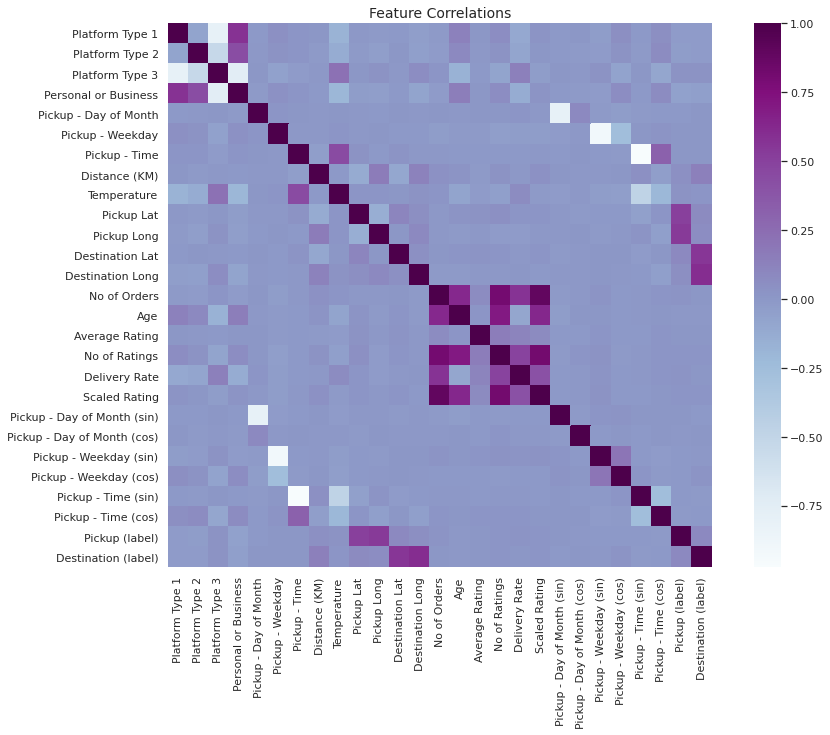

In [63]:
X_train_scaled_df['Time from Pickup to Arrival'] = y_train

fig,axis = plt.subplots(figsize=(15, 10))
sns.heatmap(X_train_df.corr(), square=True, cmap='BuPu')
plt.title('Feature Correlations',fontsize=14)

plt.show()

In [64]:
# Fit model using statsmodels.OLS
dfm = X_train_scaled_df.copy()
# Target variable:
y_name = 'Time from Pickup to Arrival'
# All available features
X_names = [col for col in dfm.columns if col != y_name]
# Build OLS formula string " y ~ X "
formula_str = "dfm['" + y_name + "']" + " ~ "+" + ".join("dfm['{0}']".format(x) for x in X_names);
# Fit model using model dataframe
model=ols(formula=formula_str, data=dfm)
fitted = model.fit()
# Fitted summary
print(fitted.summary())

                                    OLS Regression Results                                    
Dep. Variable:     dfm['Time from Pickup to Arrival']   R-squared:                       0.352
Model:                                            OLS   Adj. R-squared:                  0.351
Method:                                 Least Squares   F-statistic:                     325.2
Date:                                Fri, 17 Jul 2020   Prob (F-statistic):               0.00
Time:                                        10:09:39   Log-Likelihood:            -1.3033e+05
No. Observations:                               16201   AIC:                         2.607e+05
Df Residuals:                                   16173   BIC:                         2.609e+05
Df Model:                                          27                                         
Covariance Type:                            nonrobust                                         
                                         coef    s

For the feature selection process, we tried many different combinations of features based on their correlations and significant p-values, as well as implementing the **Recursive Feature Elimination (RFE)** function from scikit-learn. However, we will only include the final set of features that resulted in the best RMSE score for our model in this notebook.

In [65]:
# Recursive Feature Elimination
lgbm_model = lgbm.LGBMRegressor(learning_rate=0.1, min_data_in_leaf=250, num_leaves=50, objective='regression')
rfe = RFE(lgbm_model, 13)
rfe = rfe.fit(X_train, y_train)
# Summarize the selected features
keep_df = pd.DataFrame(rfe.support_,X_train_df.columns).reset_index()
keep_df = keep_df[keep_df[0]==True]
keep_df = keep_df.drop(0,axis=1)
keep_df.rename(columns={'index':'Feature'}).style.hide_index()

Feature
Pickup - Day of Month
Pickup - Time
Distance (KM)
Temperature
Pickup Lat
Pickup Long
Destination Lat
Destination Long
No of Orders
Age


In [66]:
# Final features used in model
features = ['Pickup - Day of Month', 'Pickup - Weekday', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'No of Orders',
       'Age', 'Average Rating', 'No of Ratings']
X_all = pd.DataFrame(X_all_df.loc[:,features],columns=features).values
X_train = pd.DataFrame(X_train_df.loc[:,features],columns=features).values
X_val = pd.DataFrame(X_val_df.loc[:,features],columns=features).values
X_test = pd.DataFrame(X_test_df.loc[:,features],columns=features).values
X_train_scaled = pd.DataFrame(X_train_scaled_df.loc[:,features],columns=features).values
X_val_scaled = pd.DataFrame(X_val_scaled_df.loc[:,features],columns=features).values

<a id="modelling"></a>
## 6. Modelling

### Linear Regression

Simple linear regression is a statistical method that shows the relationship between two continuous variables. This is represented by a straight line with the equation:
$$ y = a + bx$$   
where $a$ is the intercept of the line with the y-axis, and $b$ is the gradient.  
The independent variable ($x$) is also known as the predictor and the dependent variable ($y$) is known as the target.

In [67]:
# Distance (KM) has the highest correlation to our target
modelstart= time.time()
lm = LinearRegression()
lm.fit(X_train[:,3].reshape(-1, 1), y_train)
y_pred_lm = lm.predict(X_val[:,3].reshape(-1, 1))
lm_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred_lm))
lm_r2 = metrics.r2_score(y_val, y_pred_lm)

print("Testing: Linear Regression")
print('RMSE:', lm_rmse)
print('R-squared:', lm_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Linear Regression
RMSE: 746.0752361124163
R-squared: 0.37373126985581584
Model Runtime: 0.01 seconds


### Multiple Linear Regression

Multiple linear regression is an extension of simple linear regression. Instead of using one independent variable to predict the target variable, two or more independent variables are used. The multiple linear regression equation is:


$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n$$

In [68]:
modelstart= time.time()
ml = LinearRegression()
ml.fit(X_train, y_train)
y_pred_ml = ml.predict(X_val)
ml_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred_ml))
ml_r2 = metrics.r2_score(y_val, y_pred_ml)

print("Testing: Multiple Linear Regression")
print('RMSE:', ml_rmse)
print('R-squared:', ml_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Multiple Linear Regression
RMSE: 741.0480247588038
R-squared: 0.38214269508135057
Model Runtime: 0.02 seconds


### Polynomial Regression

Polynomial linear regression uses the same principles of multiple linear regression. However, alternative to fitting a line of best fit through the data, it fits a curve. The relationship between the independent variables and the dependent variable is modelled as an nth degree polynomial in the independent  variable. The polynomial linear regresion eqaution is: 

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_1^2 + ... + \beta_nX^n_1$$

In [69]:
modelstart= time.time()
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X_train)
regressor = LinearRegression()
regressor.fit(X_poly, y_train)
y_pred_poly = regressor.predict(poly_reg.transform(X_val))
pl_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred_poly))
pl_r2 = metrics.r2_score(y_val, y_pred_poly)

print("Testing: Polynomial Regression")
print('RMSE:', pl_rmse)
print('R-squared:', pl_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Polynomial Regression
RMSE: 718.9103309399072
R-squared: 0.4185064165187502
Model Runtime: 0.14 seconds


### Support Vector Regression

Support vector regression is characterized by the use of kernels, sparse solutions and VC control of the margin and the number of support vectors.

In [70]:
modelstart= time.time()
sv = SVR(kernel = 'linear')
sv.fit(X_train_scaled, y_train)
y_pred = sv.predict(X_val_scaled)
sv_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred))
sv_r2 = metrics.r2_score(y_val, y_pred)

print("Testing: Support Vector Regression")
print('RMSE:', sv_rmse)
print('R-squared:', sv_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Support Vector Regression
RMSE: 771.7113858705753
R-squared: 0.32995295925735857
Model Runtime: 12.97 seconds


### Random Forest Regression

Random forest models are an example of an ensemble method that is built on decision trees (i.e. it relies on aggregating the results of an ensemble of decision trees). Decision tree machine learning models represent data by partitioning it into different sections based on questions asked of independent variables in the data. Training data is placed at the root node and is then partitioned into smaller subsets which form the 'branches' of the tree. In random forest models, the trees are randomized and the model returns the mean prediction of all the individual trees.

In [71]:
modelstart= time.time()
rf = RandomForestRegressor(random_state = 0, n_estimators= 300)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rf_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred))
rf_r2 = metrics.r2_score(y_val, y_pred)

print("Testing: Random Forest Regression")
print('RMSE:', rf_rmse)
print('R-squared:', rf_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Random Forest Regression
RMSE: 710.7136831607784
R-squared: 0.4316906105399958
Model Runtime: 51.26 seconds


### Lasso Regression

A LASSO model is fit under the constraint of minimizing the following equation:
$$\sum_{i=1}^n(y_i-(a+\sum_{j=1}^pb_jx_{ij}))^2 + \alpha\sum_{j=1}^p|b_j|$$

which can be rewritten as $$\min_{\beta} (RSS + \alpha(L1\_norm))$$

Where $L1\_norm$ is the sum of the _absolute_ values of the coefficients.

In [72]:
modelstart= time.time()
lasso = Lasso(alpha =0.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_val)
ls_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred))
ls_r2 = metrics.r2_score(y_val, y_pred)

print("Testing: Lasso Regression")
print('RMSE:', ls_rmse)
print('R-squared:', ls_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Lasso Regression
RMSE: 741.0425109687009
R-squared: 0.38215188941884326
Model Runtime: 0.02 seconds


### Ridge Regression

Ridge regression is a technique for analyzing multiple regression data that suffer from multicollinearity by standardising the variables.

In [73]:
modelstart= time.time()
ridge = Ridge(alpha =0.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_val)
rd_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred))
rd_r2 = metrics.r2_score(y_val, y_pred)

print("Testing: Ridge Regression")
print('RMSE:', rd_rmse)
print('R-squared:', rd_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: Ridge Regression
RMSE: 741.0481109266356
R-squared: 0.3821425513945028
Model Runtime: 0.01 seconds


### CatBoost Regression


CatBoost is a machine learning algorithm that uses gradient boosting on decision trees.

In [74]:
modelstart= time.time()
cb_model = CatBoostRegressor(iterations=700,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 0,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
cb_model.fit(X_train, y_train, eval_set=(X_val,y_val), use_best_model=True,verbose=True)
y_pred_val = cb_model.predict(X_val)
cb_model_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred_val))
cb_model_r2 = metrics.r2_score(y_val, y_pred_val)
print('RMSE:', cb_model_rmse)
print('R-squared:', cb_model_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

0:	learn: 930.6651024	test: 936.5385749	best: 936.5385749 (0)	total: 294ms	remaining: 3m 25s
75:	learn: 724.1110405	test: 747.3944861	best: 747.3944861 (75)	total: 9.56s	remaining: 1m 18s
150:	learn: 665.6146529	test: 720.1050532	best: 720.1050532 (150)	total: 18.9s	remaining: 1m 8s
225:	learn: 631.0021632	test: 711.9731384	best: 711.9731384 (225)	total: 28.1s	remaining: 58.9s
300:	learn: 601.6229218	test: 708.2241406	best: 708.2241406 (300)	total: 37.4s	remaining: 49.5s
375:	learn: 574.5173306	test: 706.0410537	best: 706.0410537 (375)	total: 46.7s	remaining: 40.2s
450:	learn: 550.2253548	test: 704.1763205	best: 704.1763205 (450)	total: 55.8s	remaining: 30.8s
525:	learn: 527.2966028	test: 703.1137343	best: 703.1137343 (525)	total: 1m 5s	remaining: 21.5s
600:	learn: 507.9131191	test: 702.0880361	best: 702.0880361 (600)	total: 1m 14s	remaining: 12.2s
675:	learn: 488.7142281	test: 701.4773182	best: 701.4134134 (673)	total: 1m 23s	remaining: 2.96s
699:	learn: 482.8429650	test: 701.4938660	

### XGBoost Regression

XGBoost (e**X**treme **G**radient **B**oosting) is  a decision-tree-based algorithm that provides  scalability and uses gradient boosting framework for efficiency, flexibility  and portability.

In [75]:
modelstart= time.time()
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_val)
xg_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred))
xg_r2 = metrics.r2_score(y_val, y_pred)

print("Testing: XGBoost")
print('RMSE:', xg_rmse)
print('R-squared:', xg_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

[10:20:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Testing: XGBoost
RMSE: 703.6655596761495
R-squared: 0.44290652933220875
Model Runtime: 1.14 seconds


### LightGBM Regression

Lightgmb (**Light** **G**radient **B**oosting **M**achine)  is a gradient boosting framework that uses tree based learning algorithms (decision trees) for better accuracy, lower memory usage and capability  of handling large-scale data.

In [76]:
modelstart= time.time()
lgbm_model = lgbm.LGBMRegressor(learning_rate=0.1, min_data_in_leaf=250, num_leaves=50, objective='regression')
lgbm_model.fit(X_train,y_train)
y_pred = lgbm_model.predict(X_val)
lgbm_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred))
lgbm_r2 = metrics.r2_score(y_val, y_pred)

print("Testing: LightGBM")
print('RMSE:', lgbm_rmse)
print('R-squared:', lgbm_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))

Testing: LightGBM
RMSE: 690.4847425021319
R-squared: 0.46358161944099774
Model Runtime: 0.51 seconds


<a id="evaluation"></a>
## 7. Performance Evaluation

We can compare the performance of each of our models using two statistical measures that determine the average squared difference between the estimated values and the actual value (**MSE**) and the proportion of variance explained by the model (**R2**):  

**Mean Squared Error (MSE):**  
$$MSE = \frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2$$   
   
**R-squared (R2):**
$$R^2 = 1 - \frac{\sum(y_i-\hat{y}_i)^2}{\sum(y_i-\bar{y})^2}$$  

For this project, we will be looking at the root mean squared error (RMSE). The lower the RMSE of the model, the better the regression line fits the data.

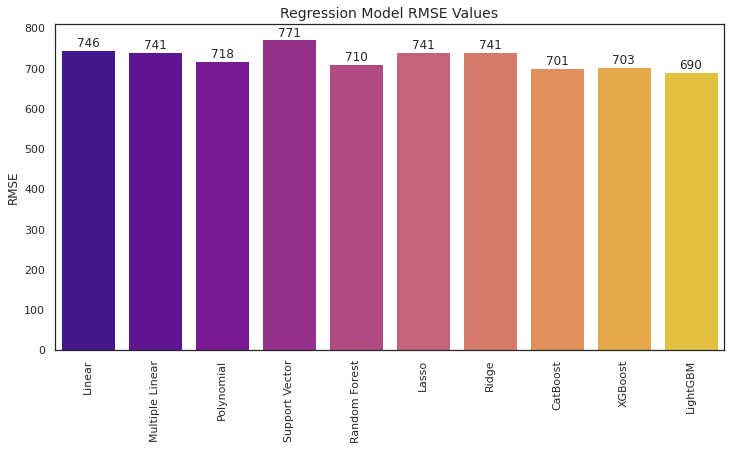

In [77]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(12, 6))
rmse_x = ['Linear','Multiple Linear','Polynomial','Support Vector','Random Forest','Lasso','Ridge','CatBoost','XGBoost','LightGBM']
rmse_y = [lm_rmse,ml_rmse,pl_rmse,sv_rmse,rf_rmse,ls_rmse,rd_rmse,cb_model_rmse,xg_rmse,lgbm_rmse]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='plasma')
plt.title('Regression Model RMSE Values',fontsize=14)
plt.ylabel('RMSE')
plt.xticks(rotation=90)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')

plt.show()

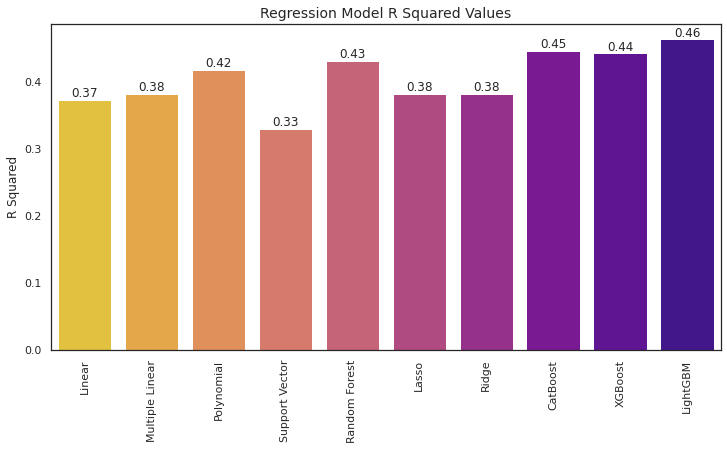

In [78]:
# Compare R squared values between models
fig,axis = plt.subplots(figsize=(12, 6))
rmse_x = ['Linear','Multiple Linear','Polynomial','Support Vector','Random Forest','Lasso','Ridge','CatBoost','XGBoost','LightGBM']
rmse_y = [lm_r2,ml_r2,pl_r2,sv_r2,rf_r2,ls_r2,rd_r2,cb_model_r2,xg_r2,lgbm_r2]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='plasma_r')
plt.title('Regression Model R Squared Values',fontsize=14)
plt.ylabel('R Squared')
plt.xticks(rotation=90)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
plt.show()

Based on the best performance metrics and quickest runtimes, we choose to evaluate the performance of the **Random Forest** and **LightGBM** models further, through cross validation, hyperparameter tuning, and feature importance.

### Evaluate Best Models by Cross Validation

Cross validation is a technique used to test the accuracy of a model's prediction on unseen data (validation sets). This is important because it can assist in picking up issues such as over/underfititng and selection bias. We used the K-fold technique to perform cross validation.

In [79]:
reg = [RandomForestRegressor(random_state=0),lgbm.LGBMRegressor(random_state=0)]
cross_val = []
for r in reg:
    cross_val.append(np.sqrt(abs(cross_val_score(r, X_train, y=y_train, scoring='neg_mean_squared_error', cv=KFold(n_splits=5, random_state=0, shuffle=True)))))
cross_val_mean = [i.mean() for i in cross_val] 
cross_val_df = pd.DataFrame({"Model": ["RandomForest", "LightGBM"],"Mean RMSE": cross_val_mean})
pd.DataFrame(cross_val_df.sort_values("Mean RMSE", ascending=True))

,Model,Mean RMSE
1,LightGBM,718.210500
0,RandomForest,740.668302


### Hyperparameter Tuning on Best Models

Hyperparameter tuning is the process by which a set of ideal hyperparameters are chosen for a model. A hyperparameter is a parameter for which the value is set manually and tuned to control the algorithm's learning process. For the LightGBM model, the number of leaves, minimum data in a leaf, the learning rate and the objective were selected as hyperparameters. Similarly for the Random Forest, the maximum number of features, the minimum number of sample splits and sample leaves, and the number of estimators were selected.

In [80]:
# LightGBM
lgbm_dict = {
    'num_leaves': [50], #[10, 50, 150]
    'min_data_in_leaf': [250], #[50, 250, 500]
    'learning_rate': [0.1], #[0.1, 0.05, 0.001]
    'objective': ['regression']}
lgbm_gridsearch = GridSearchCV(estimator = lgbm.LGBMRegressor(random_state=0), cv=KFold(n_splits=5, random_state=0, shuffle=True), scoring='neg_mean_squared_error', param_grid=lgbm_dict, n_jobs=-1)
lgbm_best = lgbm_gridsearch.fit(X_train, y_train)
lgbm_parameters = lgbm_best.best_params_
lgbm_score = np.sqrt(abs(lgbm_best.best_score_))
print('***LightGBM***')
print(round(lgbm_score,2),lgbm_parameters)

# Random Forest
rf_dict = { 
    'max_features':[5], #[1, 3, 5]
    'min_samples_split':[2], #[2, 5, 10]
    'min_samples_leaf': [1], #[1, 3]
    'n_estimators':[300]} #[100, 200, 300]
rf_gridsearch = GridSearchCV(RandomForestRegressor(random_state=0), cv=KFold(n_splits=5, random_state=0, shuffle=True), scoring='neg_mean_squared_error', param_grid=rf_dict, n_jobs=-1)
rf_best = rf_gridsearch.fit(X_train, y_train)
rf_parameters = rf_best.best_params_
rf_score = np.sqrt(abs(rf_best.best_score_))
print('***Random Forest***')
print(round(rf_score,2), rf_parameters)

***LightGBM***
716.68 {'learning_rate': 0.1, 'min_data_in_leaf': 250, 'num_leaves': 50, 'objective': 'regression'}
***Random Forest***
728.34 {'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


### Feature Importance of Best Models

Feature importance provides a score that indicates how much each feature contributes towards the prediction. The more a feature is used to make key decisions within the model, the higher its relative importance. A feature's importance can differ from model to model.

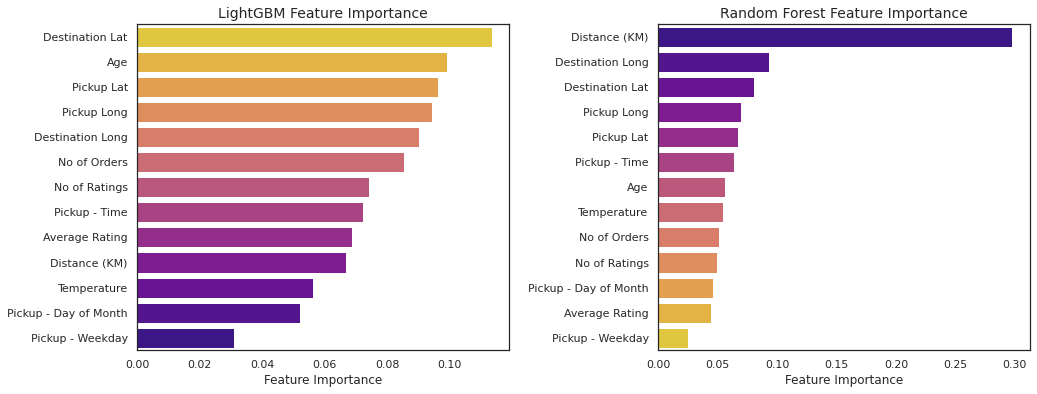

In [81]:
# Get feature importance
feat_imp = lgbm_best.best_estimator_.feature_importances_
lgbm_feat_imp = np.array([i/sum(feat_imp) for i in feat_imp])
rf_feat_imp  = rf_best.best_estimator_.feature_importances_
f_names = np.array(features)

fig,axis = plt.subplots(ncols=2, figsize=(16, 6))
plt.subplots_adjust(hspace=0.6, wspace=0.4)

# LightGBM
lgbm_ticks = np.argsort(lgbm_feat_imp)[::-1]
sns.barplot(y = f_names[lgbm_ticks], x = lgbm_feat_imp[lgbm_ticks], orient='h',palette='plasma_r', ax=axis[0])
axis[0].set_title('LightGBM Feature Importance',fontsize=14)
axis[0].set_xlabel('Feature Importance')
# Random Forest
rf_ticks = np.argsort(rf_feat_imp)[::-1]
sns.barplot(y = f_names[rf_ticks], x = rf_feat_imp[rf_ticks], orient='h',palette='plasma', ax=axis[1])
axis[1].set_title('Random Forest Feature Importance',fontsize=14)
axis[1].set_xlabel('Feature Importance')

plt.show()

The **LightGBM** model produced the best RSME value after cross validation and hyperparameter tuning. We also see that one feature has a much higher importance in the Random Forest model, which may be due to the tendency of the function to inflate the importance of continuous features in tree-based models.

<a id="analysis"></a>
## 8. Model Analysis

In [84]:
modelstart= time.time()
final_model = lgbm.LGBMRegressor(learning_rate=0.1, min_data_in_leaf=250, num_leaves=50, objective='regression')
final_model.fit(X_train,y_train)
y_pred_val_final = final_model.predict(X_val)
y_pred_test_final = final_model.predict(X_test)
final_rmse = sqrt(metrics.mean_squared_error(y_val, y_pred_val_final))
final_r2 = metrics.r2_score(y_val, y_pred_val_final)
print("Testing: LightGBM")
print('RMSE:', final_rmse)
print('R-squared:', final_r2)
print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)/60))

Testing: LightGBM
RMSE: 690.4847425021319
R-squared: 0.46358161944099774
Model Runtime: 0.01 seconds


Correlation coefficient: 0.68


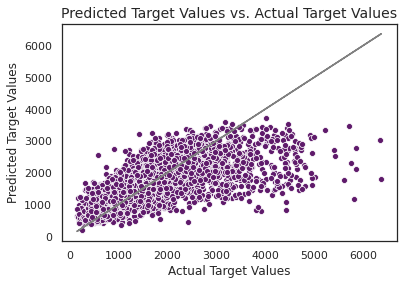

In [85]:
# Predicted Target Values vs. Actual Target Values
sns.scatterplot(x=y_val, y=y_pred_val_final, color="#5f1b6b")
plt.plot(y_val,y_val,color="gray")
plt.title("Predicted Target Values vs. Actual Target Values", fontsize=14)
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
r = np.corrcoef(y_val,y_pred_val_final)[0,1]
print("Correlation coefficient: " + str(round(r,2)))
plt.show()

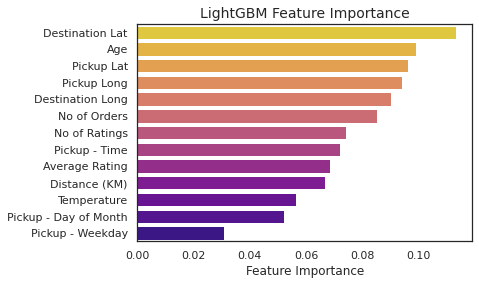

In [86]:
# Get feature importance
feat_imp = lgbm_model.feature_importances_
lgbm_feat_imp = np.array([i/sum(feat_imp) for i in feat_imp])
f_names = np.array(features)

# LightGBM
lgbm_ticks = np.argsort(lgbm_feat_imp)[::-1]
sns.barplot(y = f_names[lgbm_ticks], x = lgbm_feat_imp[lgbm_ticks], orient='h',palette='plasma_r')
plt.title('LightGBM Feature Importance',fontsize=14)
plt.xlabel('Feature Importance')

plt.show()

<a id="conclusion"></a>
## 9. Conclusion

We succeeded in building a regression model that is able to predict the time from pickup to arrival for motorbike deliveries. In order to identify the best performing model for this challenge, we tested 10 different regression models that all delivered RMSE values below 760.

Cross validation testing and hyperparameter tuning were performed on the two models that had the lowest RMSE values, the highest R-squared values, and relatively fast runtimes. Our performance evaluations show that the LightGBM regression model delivered the best RSME (690) and R-squared (0.46) values based on our validation set. The R-squared value suggests that 46% of the variation observed in the data can be explained by our model.

We also see that our chosen model performs well on the validation set, as there is a strong positive correlation of 0.68 between our predicted target values and the actual values. Almost all of the features included in the model have importance values relatively close to each other (between 0.03 and 0.1).

<a id="save"></a>
## 10. Save Model and Output

In [87]:
# Make Zindi submission file
final_model = lgbm.LGBMRegressor(learning_rate=0.1, min_data_in_leaf=250, num_leaves=50, objective='regression')
final_model.fit(X_all,y)
y_test = final_model.predict(X_test)
results = pd.DataFrame({"Order No":test_df['Order No'],"Time from Pickup to Arrival": y_test})
results.to_csv("Team19_JHB_submission.csv", index=False)

In [88]:
# Save model
model_save_path = "Team19_JHB_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(final_model,file)

Ranked 22 out of 78